In [1]:
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-004-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy import stats

templist = [-9.4, -4.4, 0.4, 5.3, 10.3, 15.3, 20, 25, 30, 35, 40]
badchannels = [18, 29, 37, 38, 44, 58]
runlist = [
           [1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595],
           [1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582],
           [1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569],
           [1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556],    
           [1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542],  
           [1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525],
           [1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1493],
           [1433, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442],
           [1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451],
           [1457, 1458, 1459, 1460, 1461 ,1462, 1463, 1464, 1465],
           [1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506]   
          ]
        
        
bias = np.array([
                 [51.6, 52.1, 52.6, 53.1, 53.6, 54.1, 54.6, 55.1, 55.6],
                 [51.9, 52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9],
                 [52.2, 52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2],
                 [52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9, 56.4],
                 [52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7],
                 [53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0],
                 [53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7, 57.2],
                 [53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5],
                 [53.8, 54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8],
                 [54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0],
                 [54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8, 58.3]
                ])

In [2]:
def processTemperature(arr, idx):

    df = pd.DataFrame(columns=['chan', 'slope', 'temp', 'intercept', 'r_value', 'p_value', 'std_err', 
                               'Vbd', 'spe_3V_over', 'spe_53V_fix', 'spe_54V_fix', 'spe_55V_fix', 'spe_60V_fix', 'spe_65V_fix'])

    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
    plt.subplots_adjust(wspace=0)
    fig.subplots_adjust(top=0.96)
    plt.suptitle("Temperature = %d C"%templist[idx])

    for hdmi, ax in enumerate(axs.flatten()):
        ax.set_xlabel("Set bias [V]")
        if(hdmi%4 == 0):
            ax.set_ylabel("PE")
        for inhdmi_chan in range(4):
            chan = hdmi*4+inhdmi_chan
            x=bias[idx]
            y=arSPE[:, 0, chan]
            mask = ~np.isnan(y)
            x=x[mask]
            y=y[mask]

            if y.size==0:
                print("Bad channel: %d"%(chan))
                continue

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            ratio = - intercept / slope
            ratio_stderr = ratio * np.sqrt((std_err / slope)**2)
            spe_3V_over = slope*(ratio + 3)+intercept

            new_row = {'chan': chan, 'slope': slope, 'temp': temp, 'intercept': intercept,
                       'r_value': r_value, 'p_value': p_value, 'std_err': ratio_stderr, 'Vbd': ratio, 
                       'spe_3V_over': spe_3V_over, 'spe_53V_fix': slope*53+intercept, 'spe_54V_fix': slope*54+intercept,
                       'spe_55V_fix': slope*55+intercept, 'spe_60V_fix': slope*60+intercept, 'spe_65V_fix': slope*65+intercept}
            df.loc[len(df)] = new_row

            markers = ax.plot(x, y, 'o', label='Chan: %d, PE = %.1f+%.1fV'%(chan, intercept, slope))
            ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
            ax.legend(fontsize='small');
    return df

Bad channel: 38
Bad channel: 38
Bad channel: 58


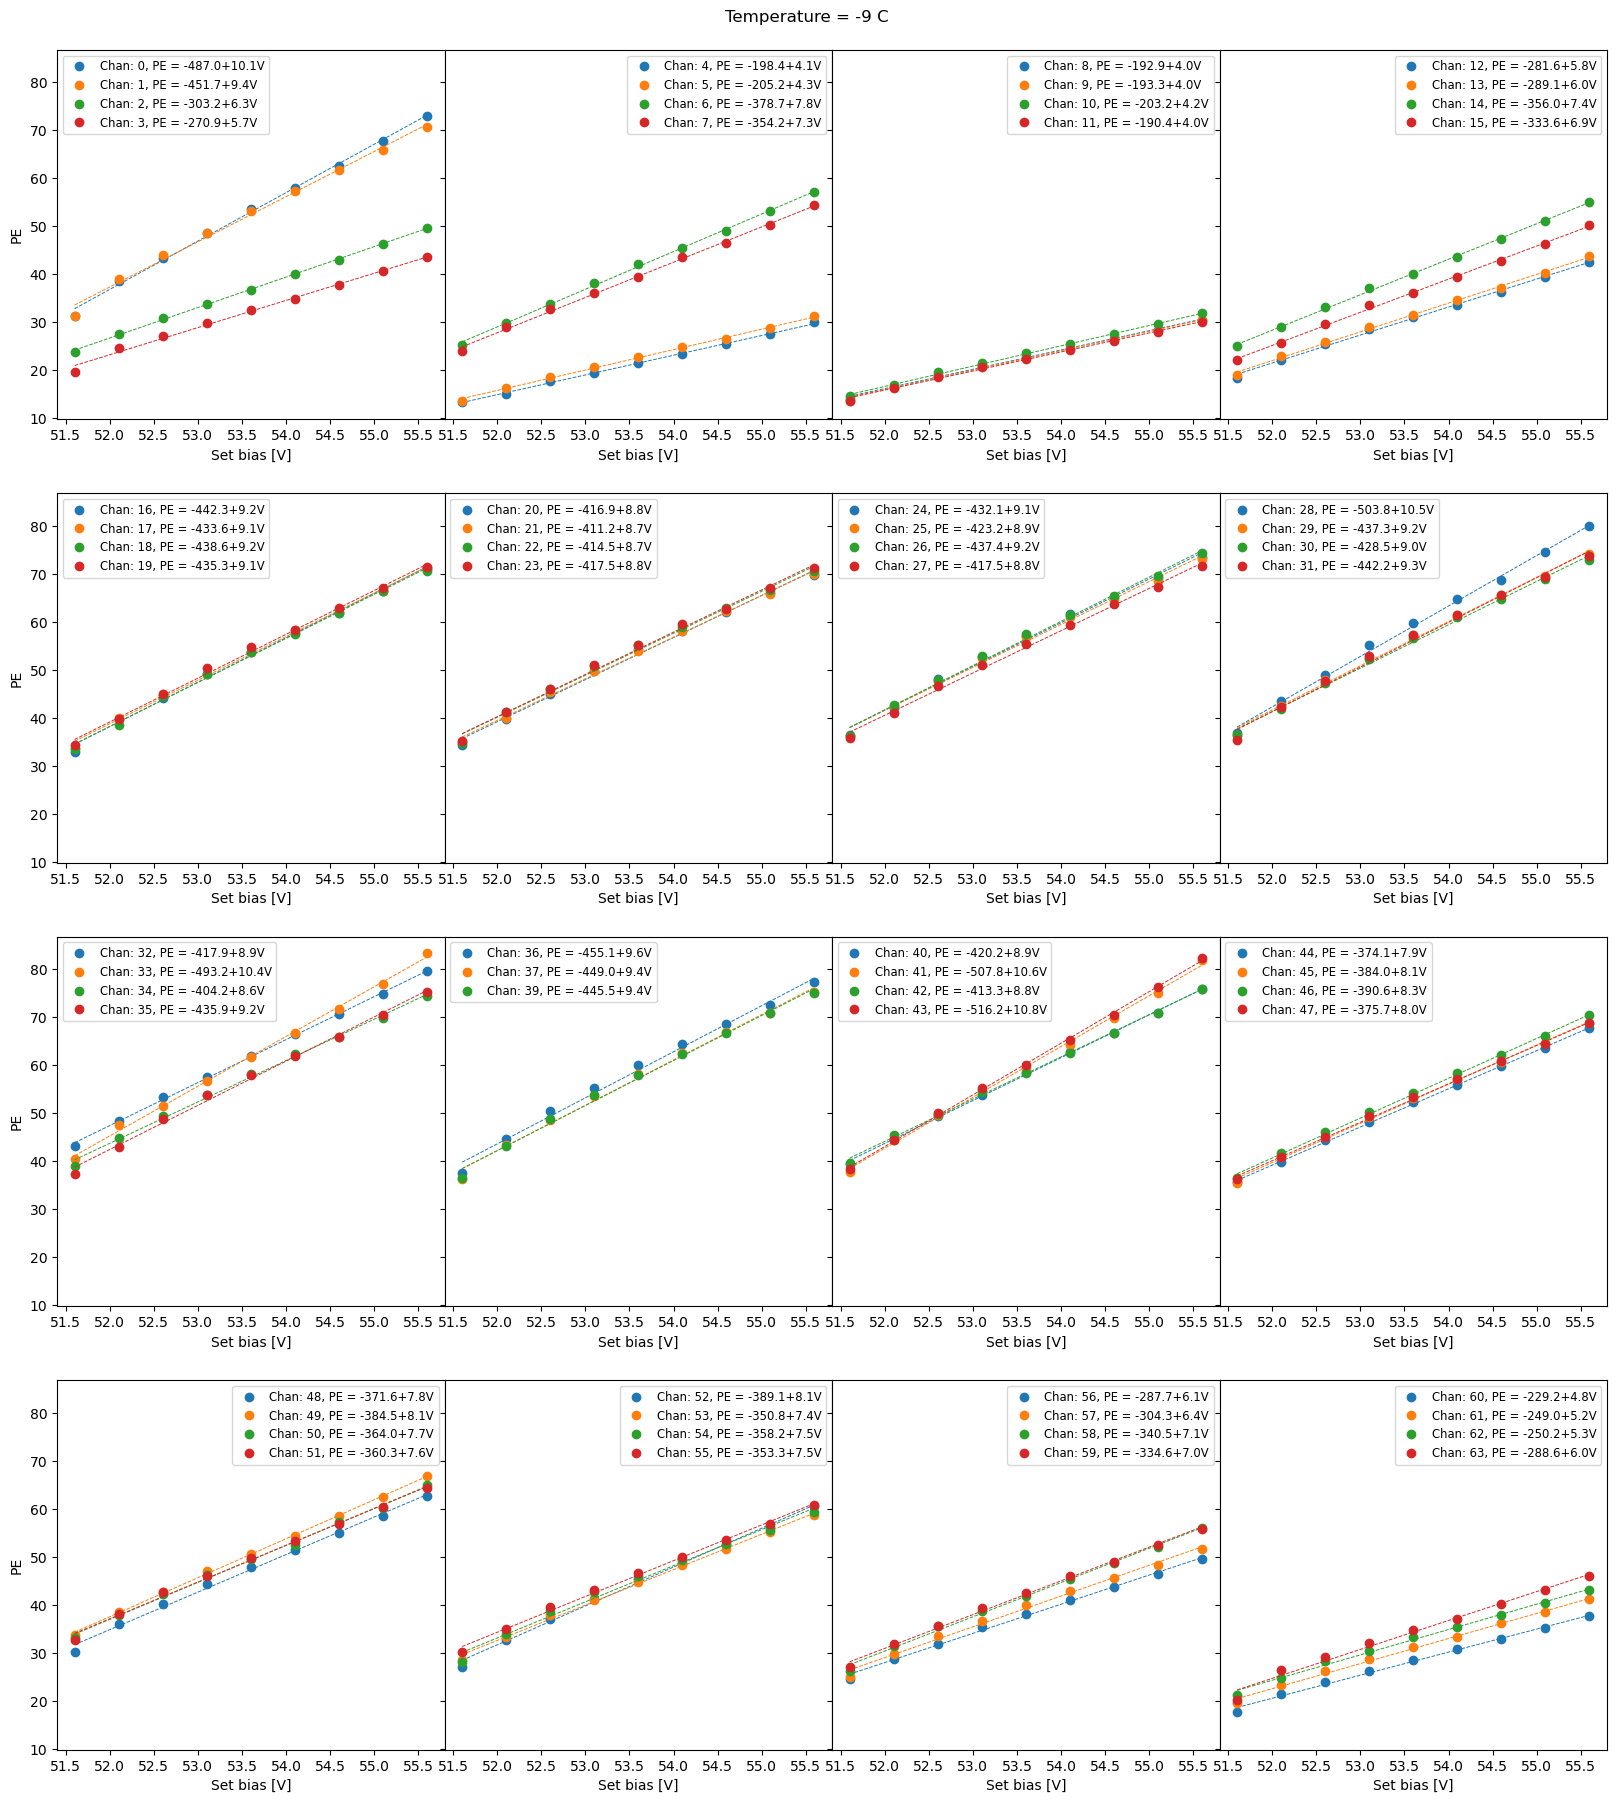

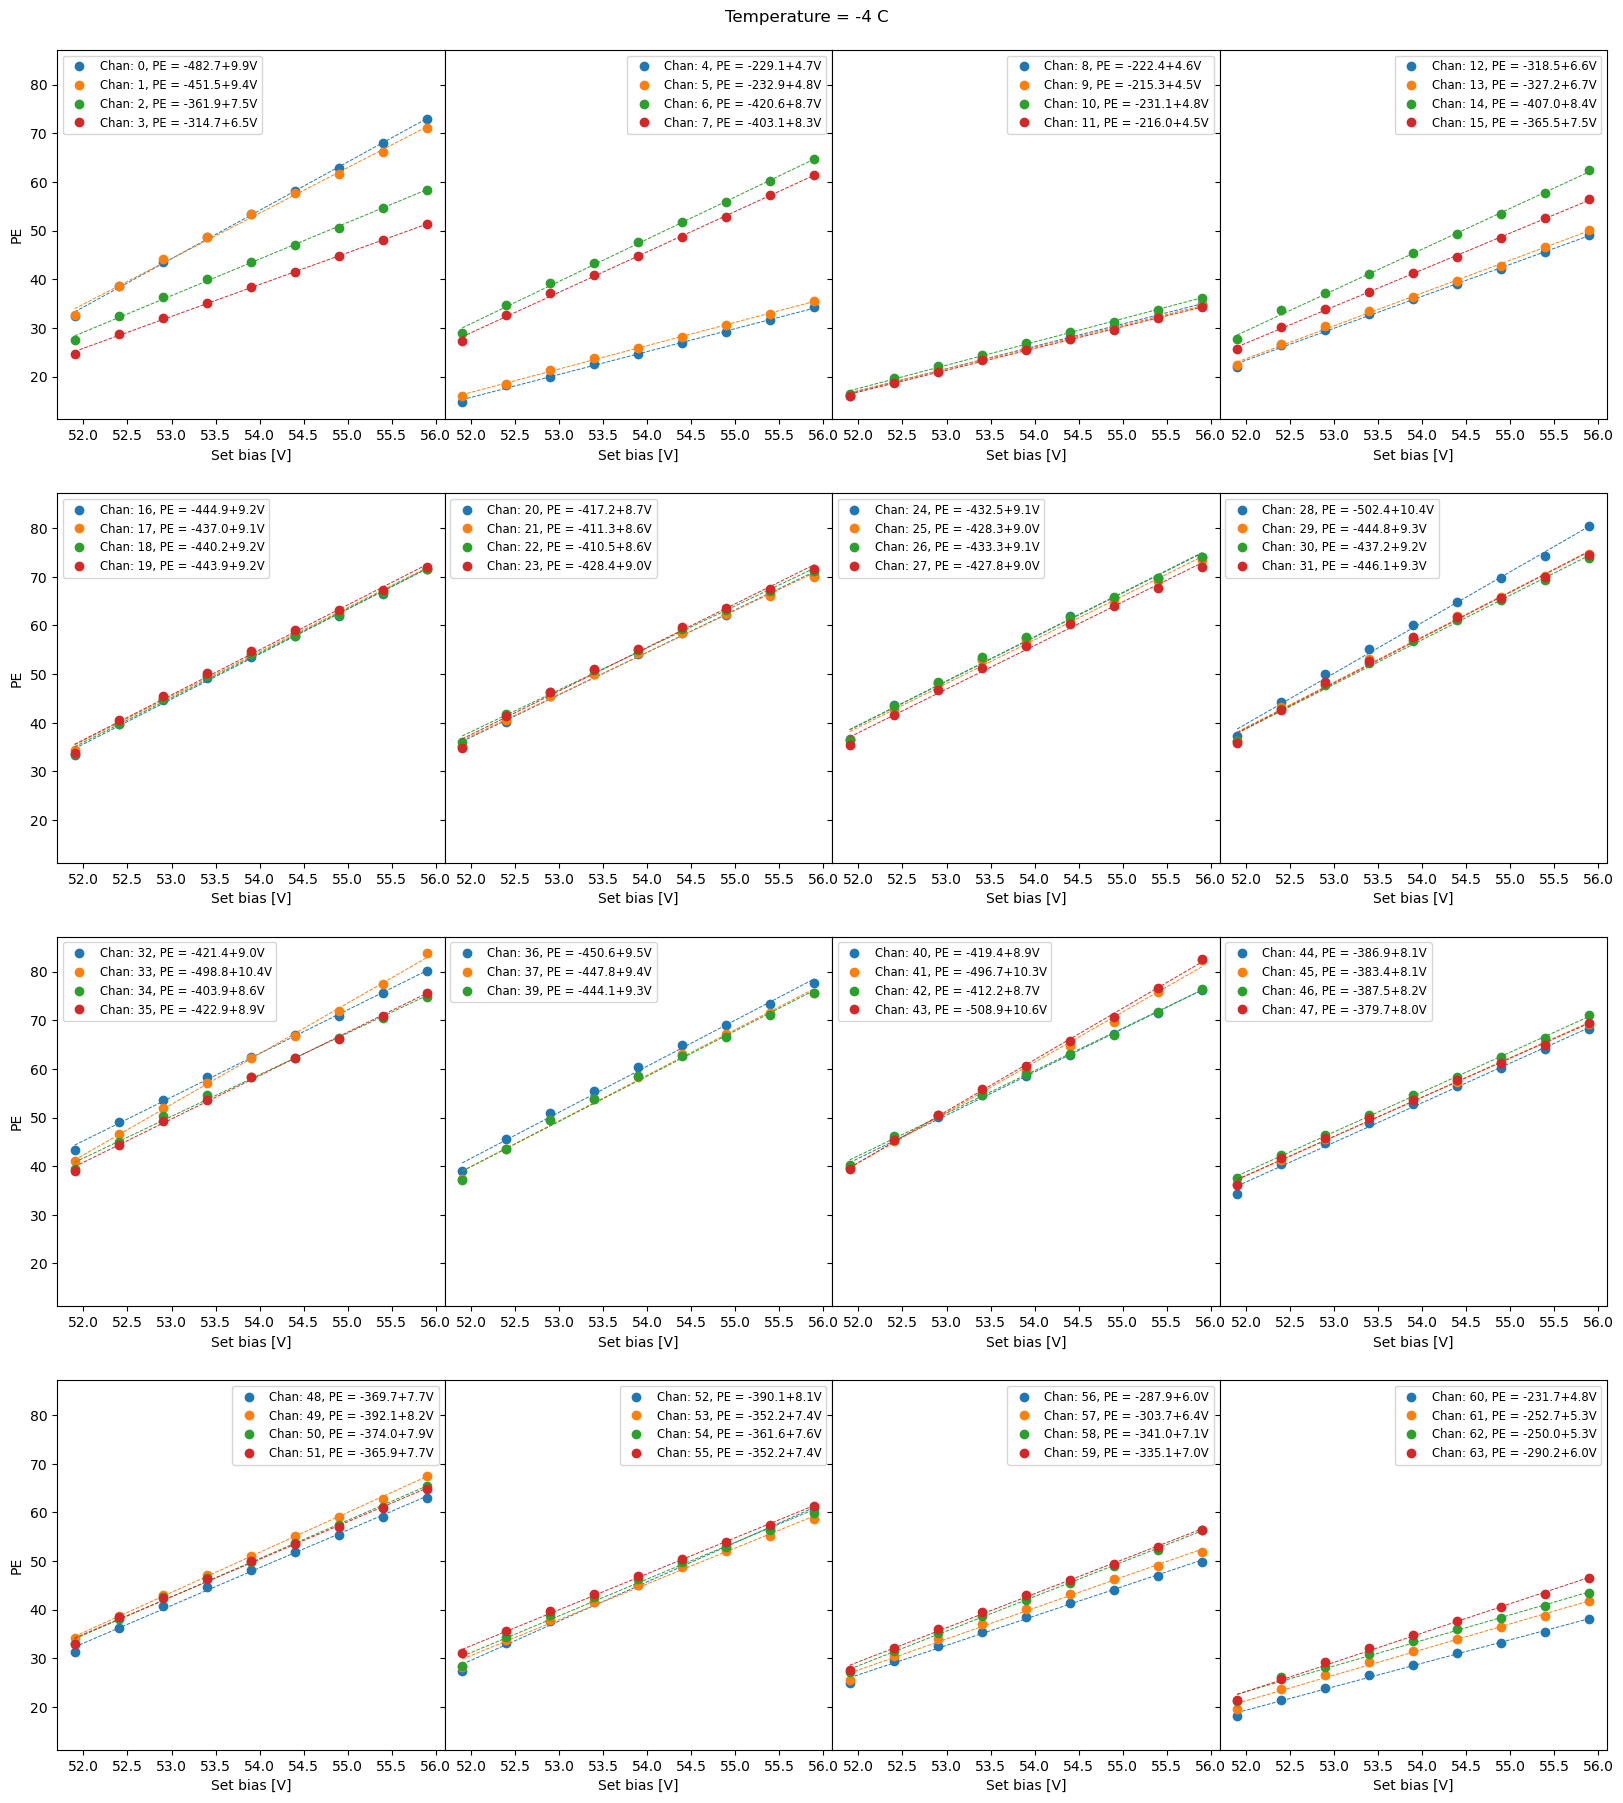

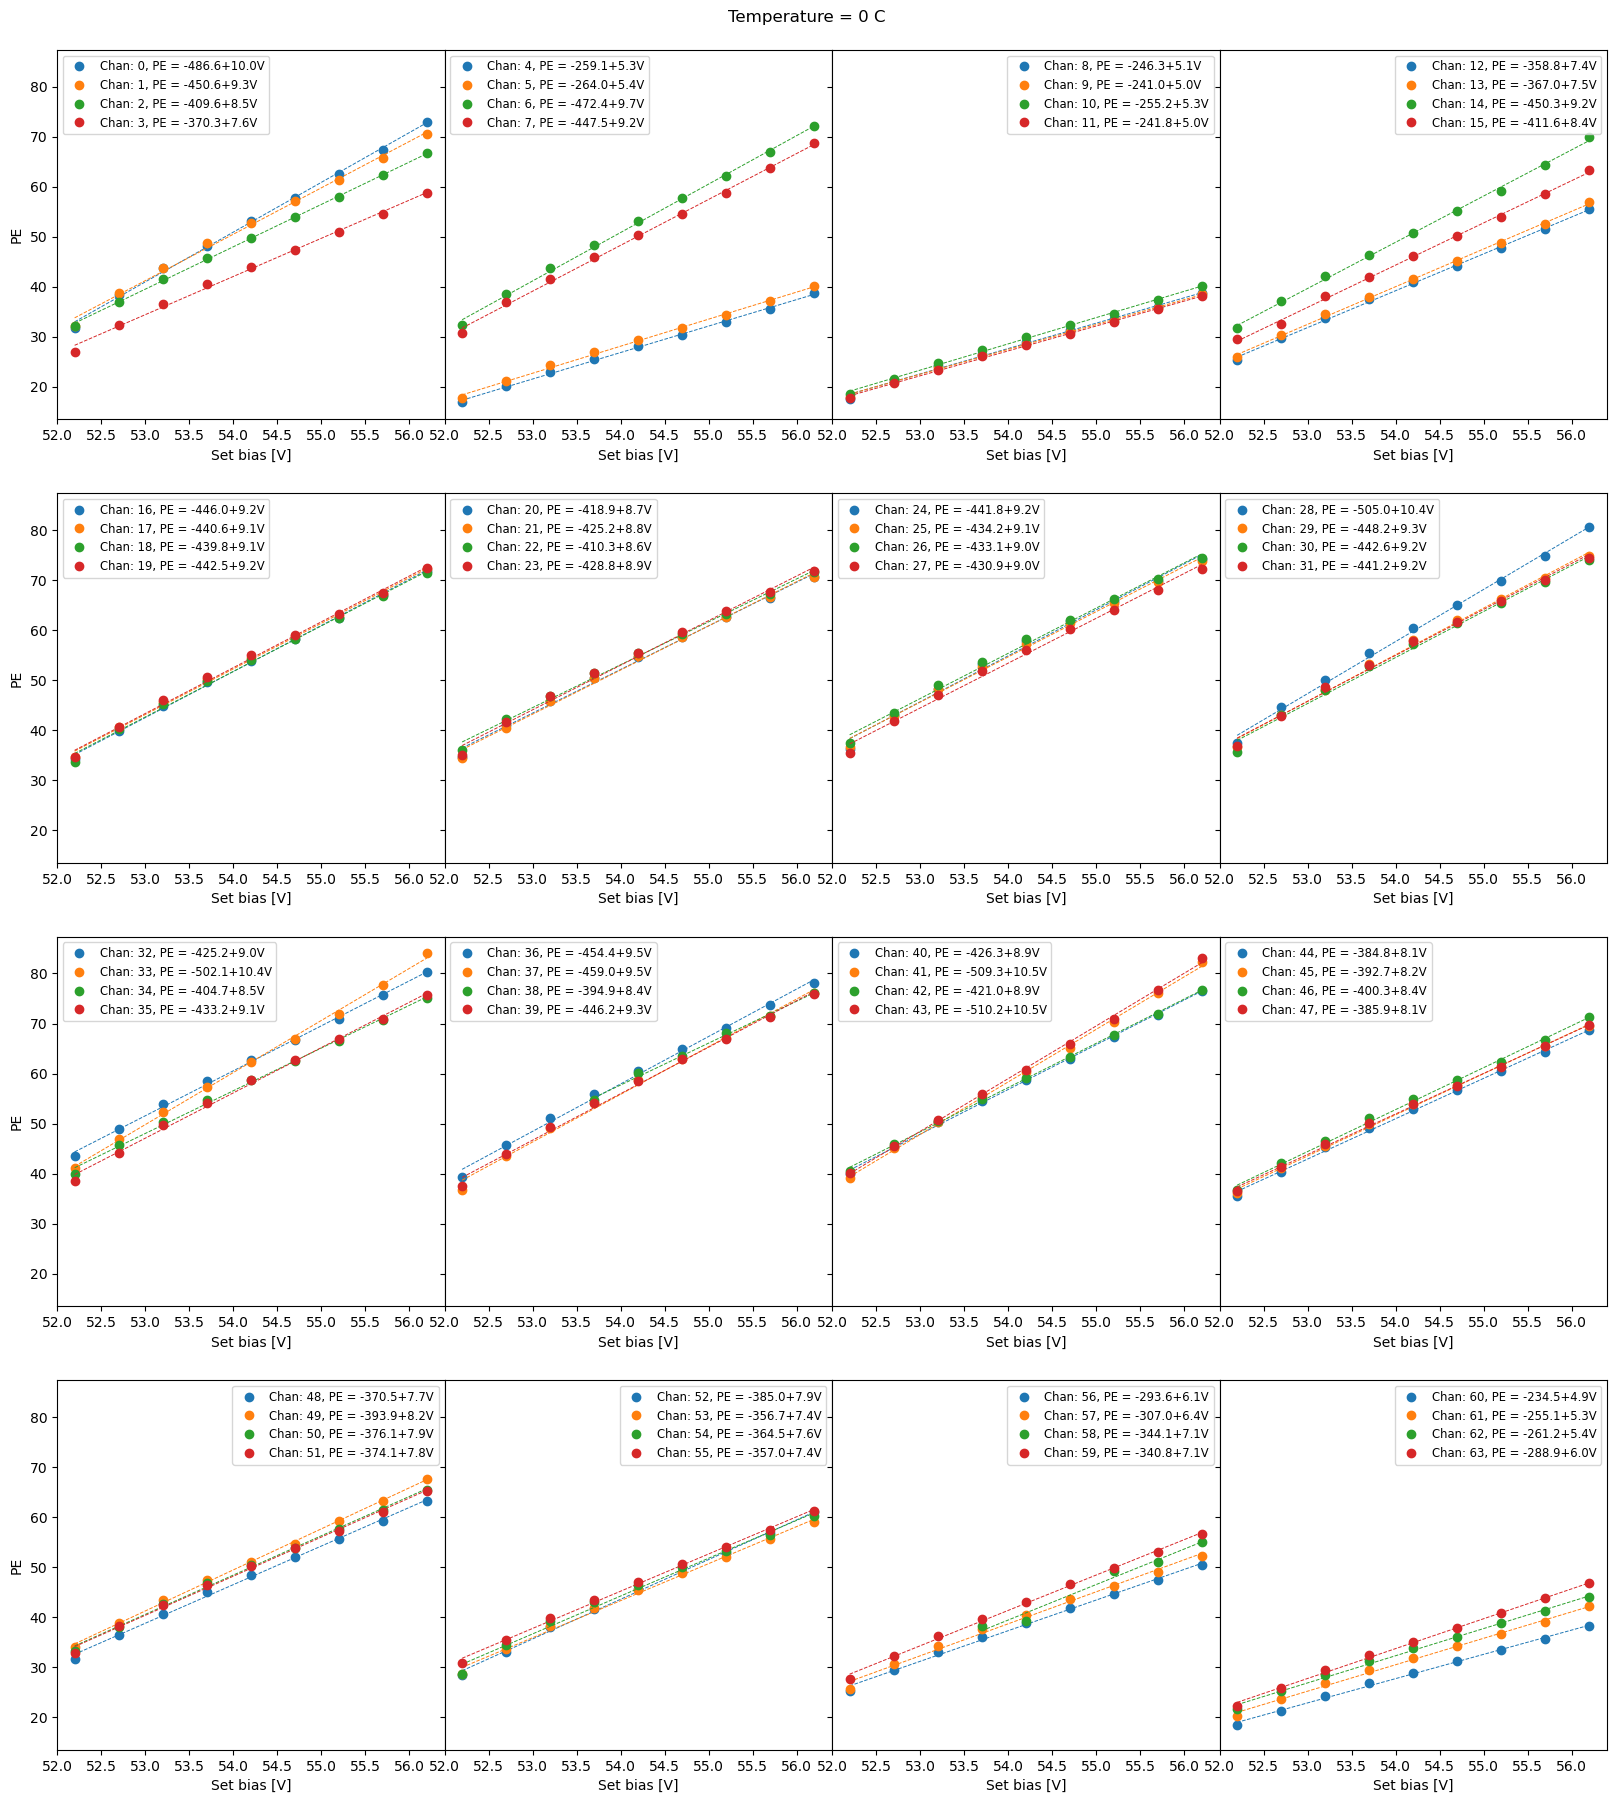

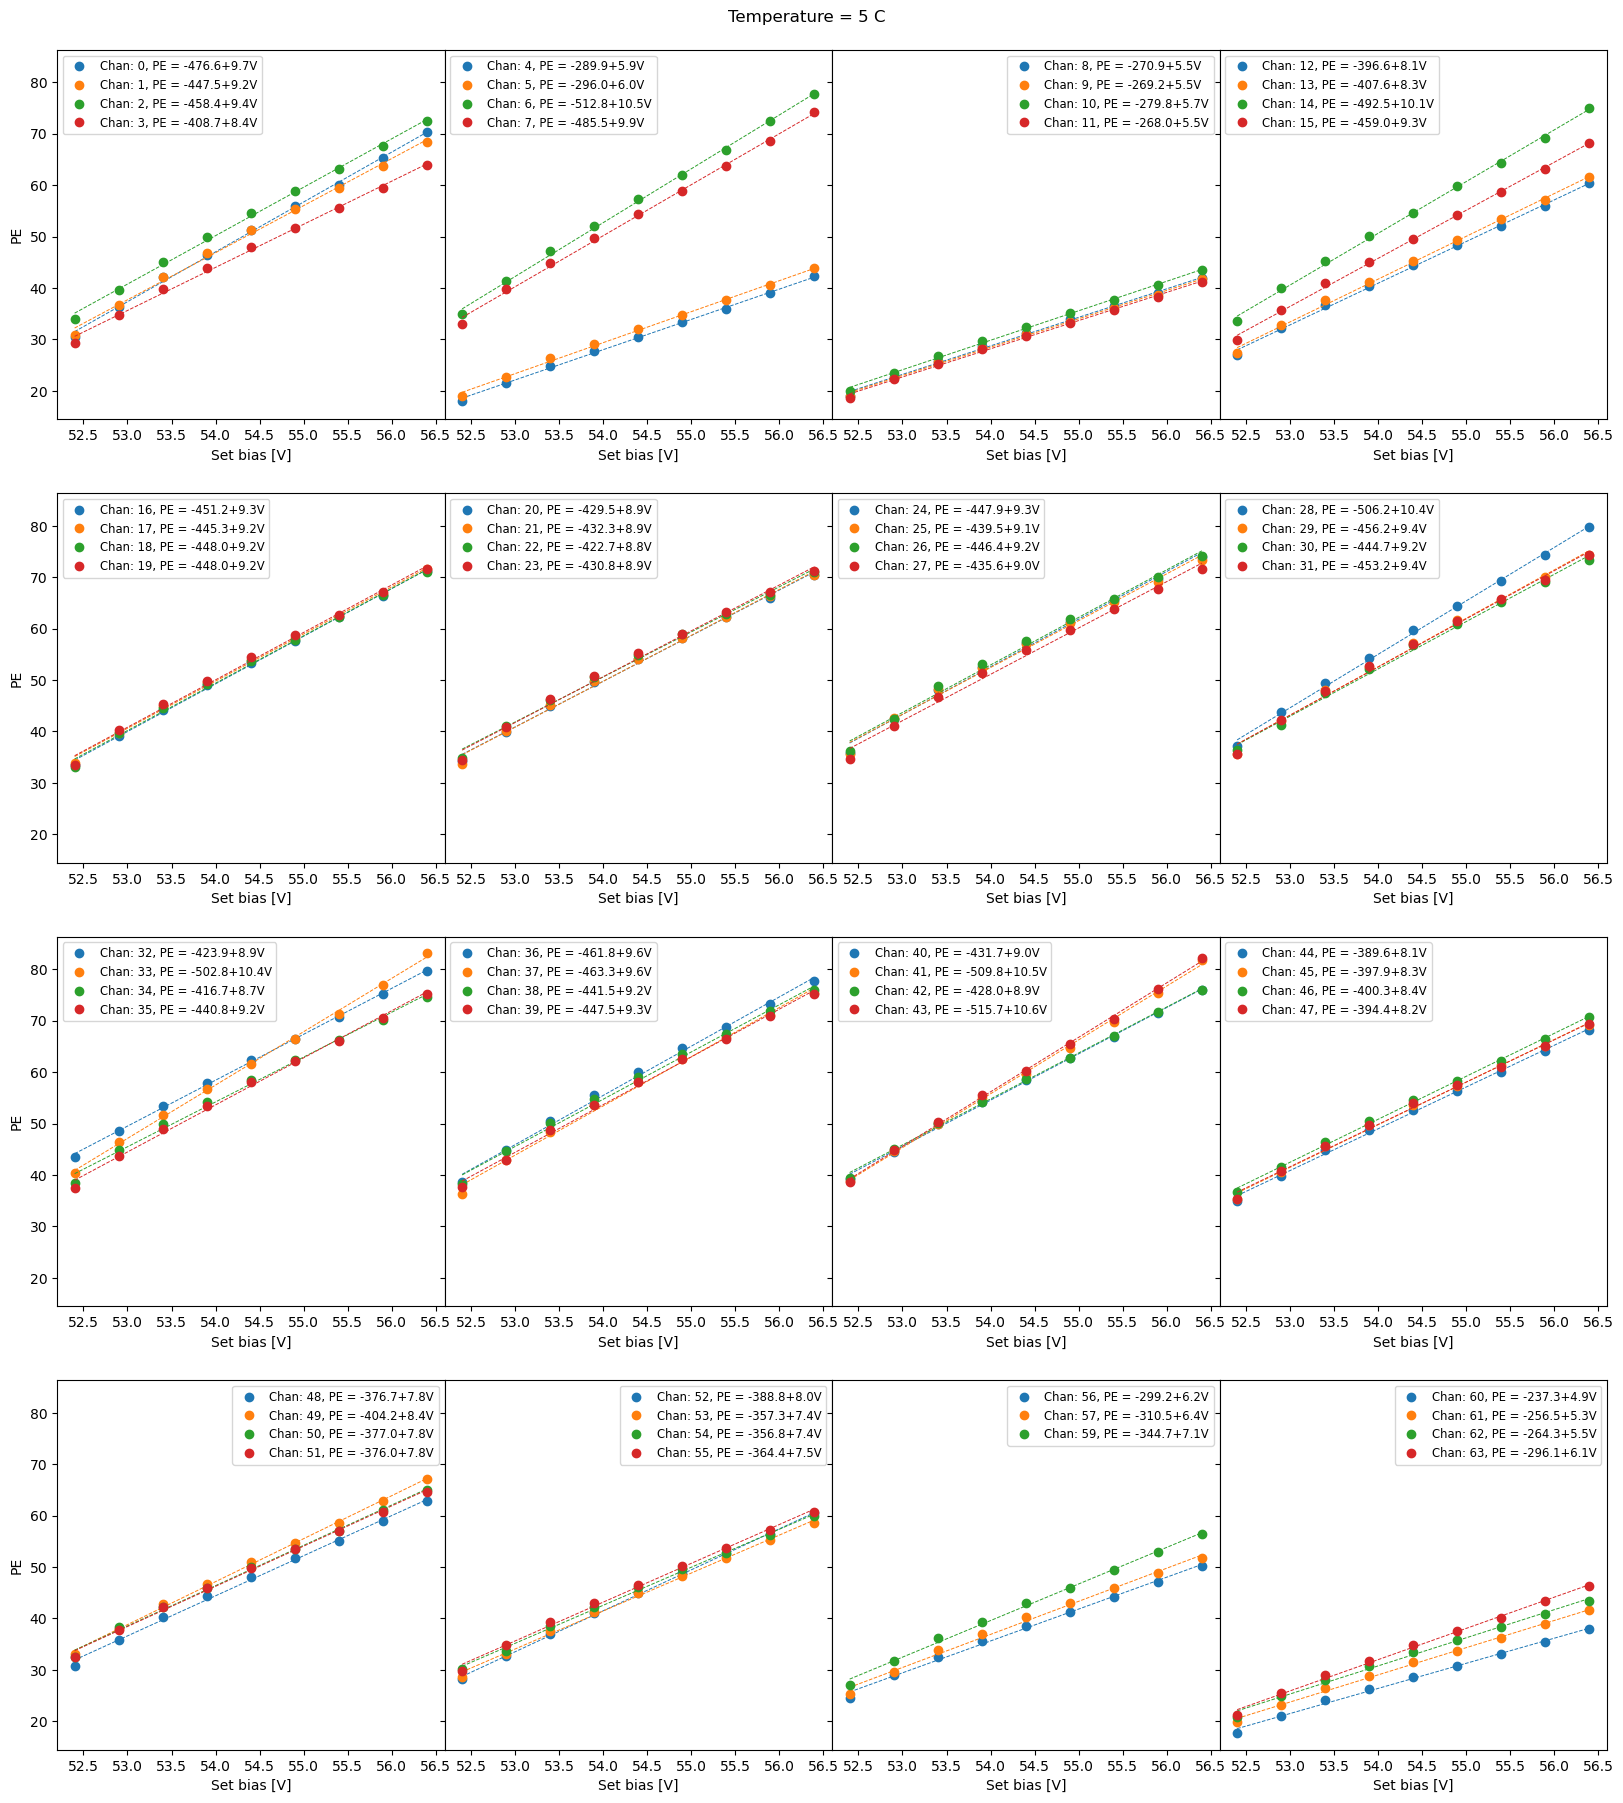

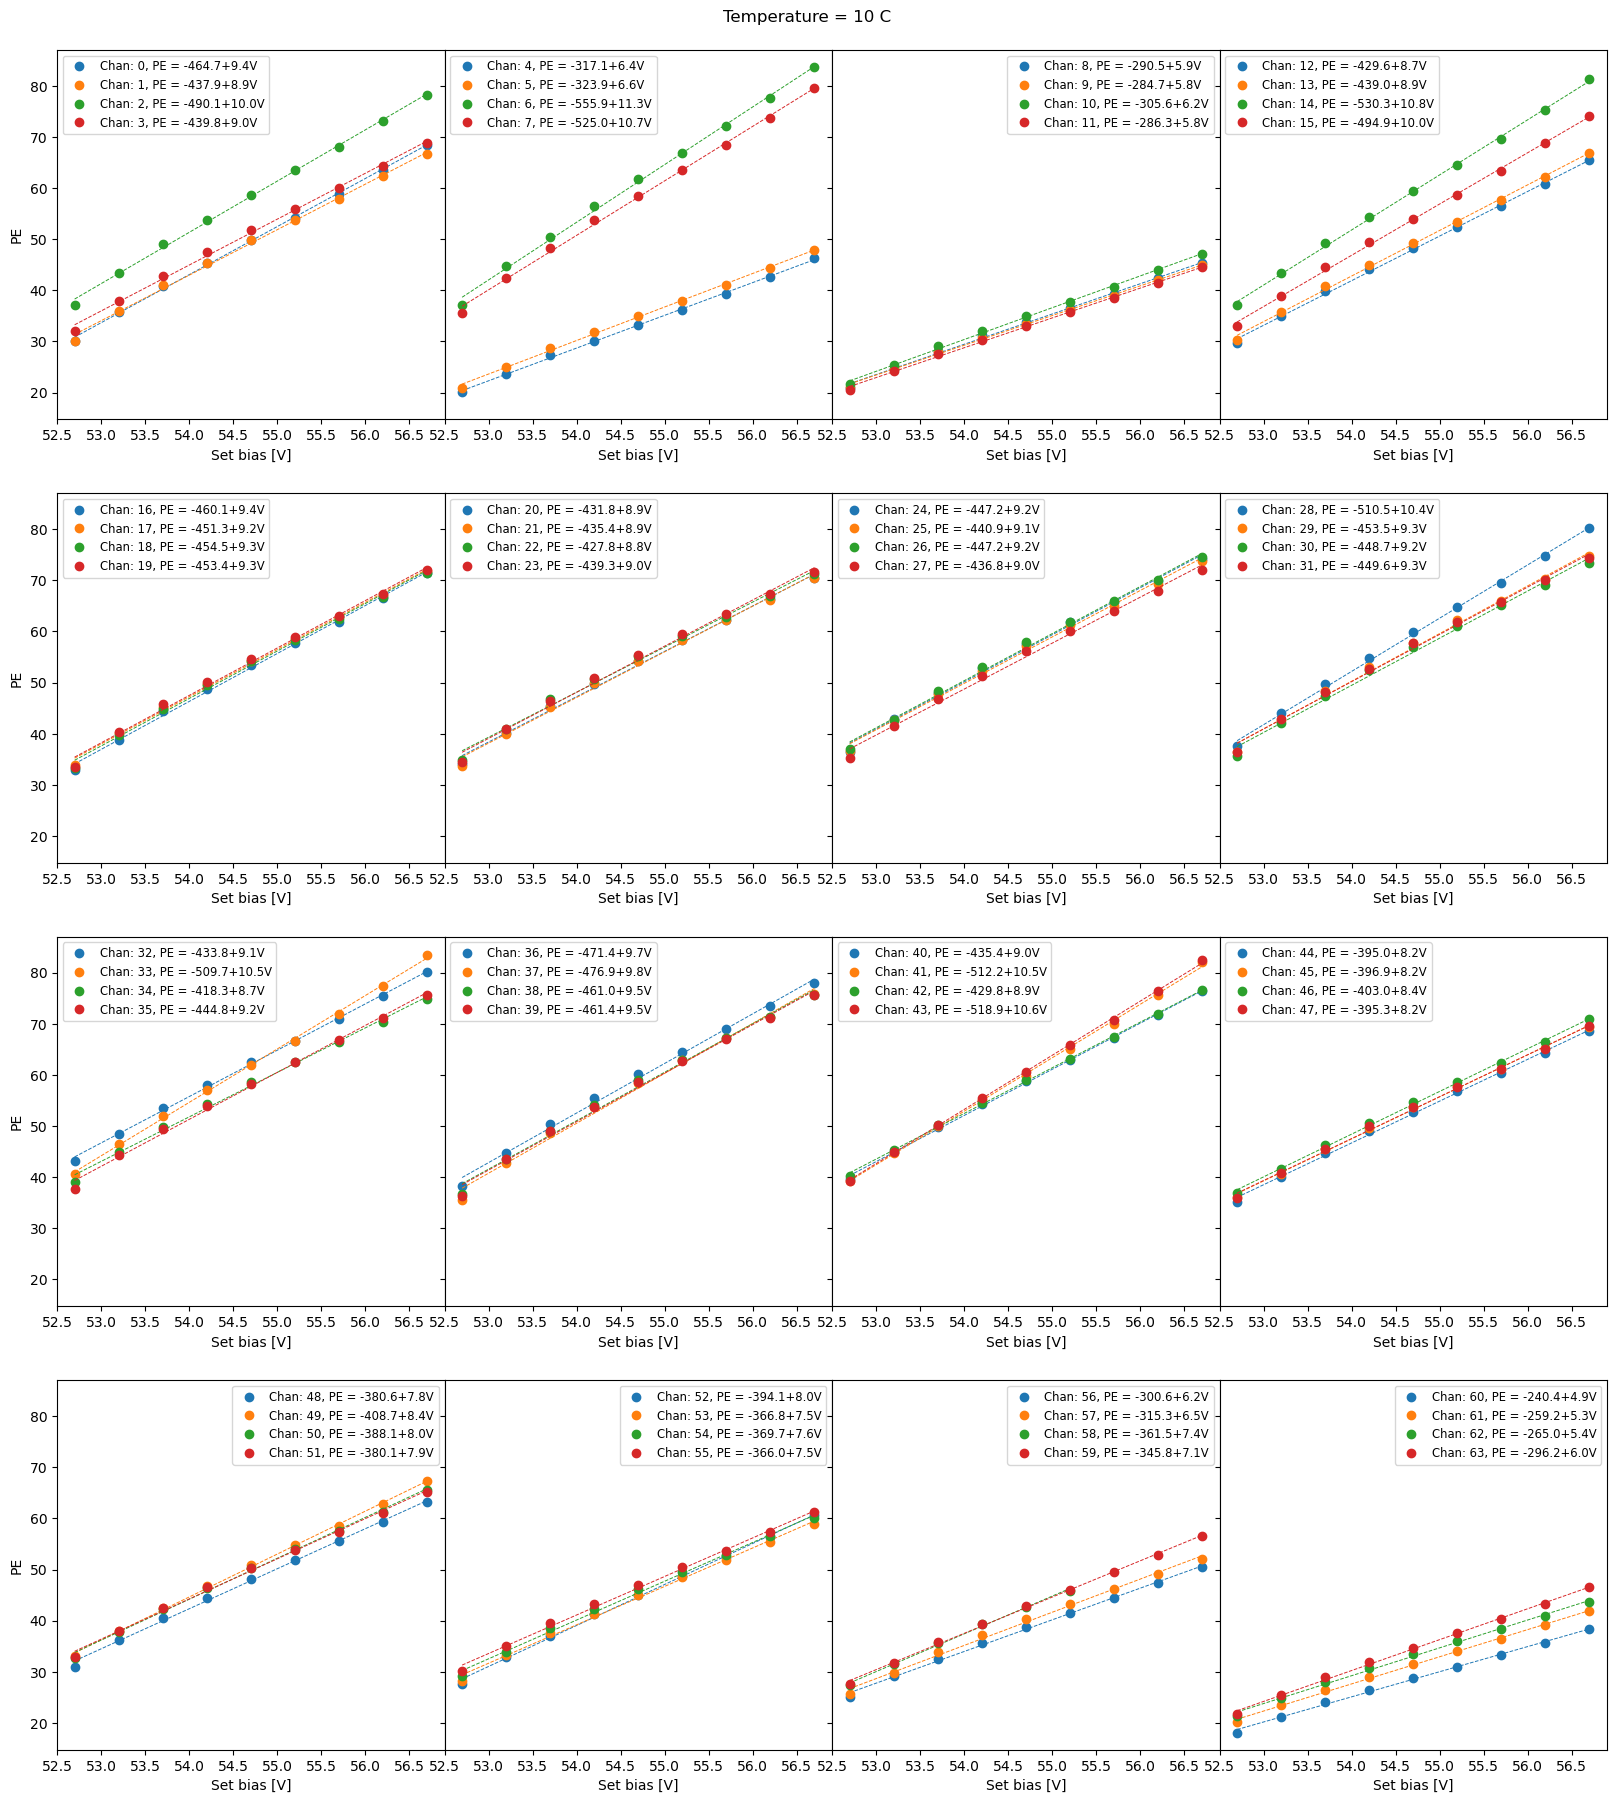

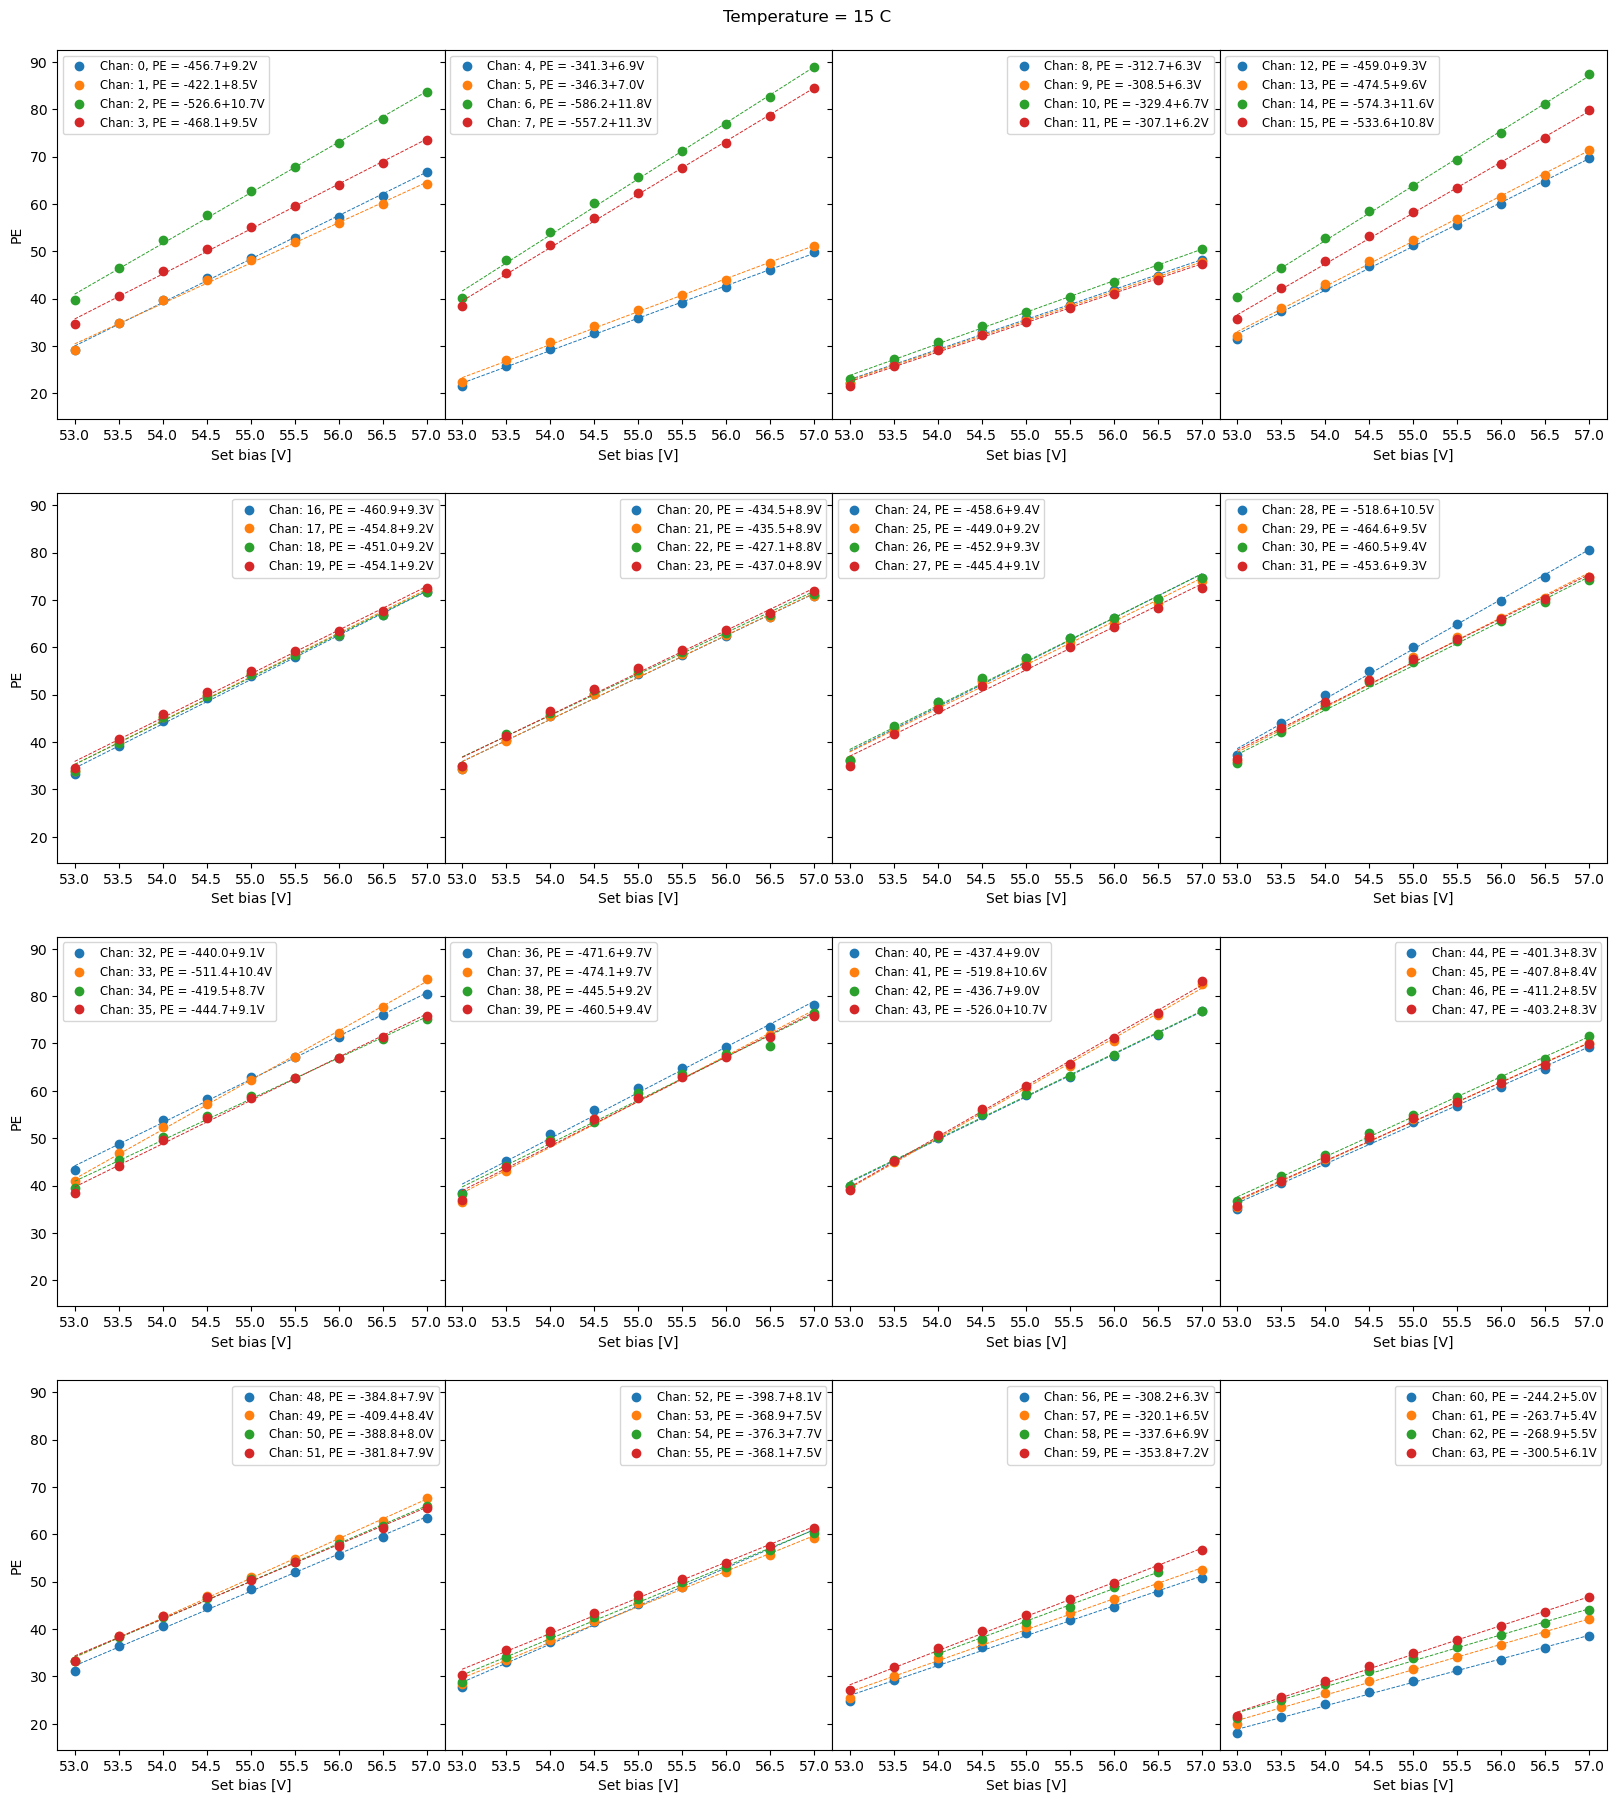

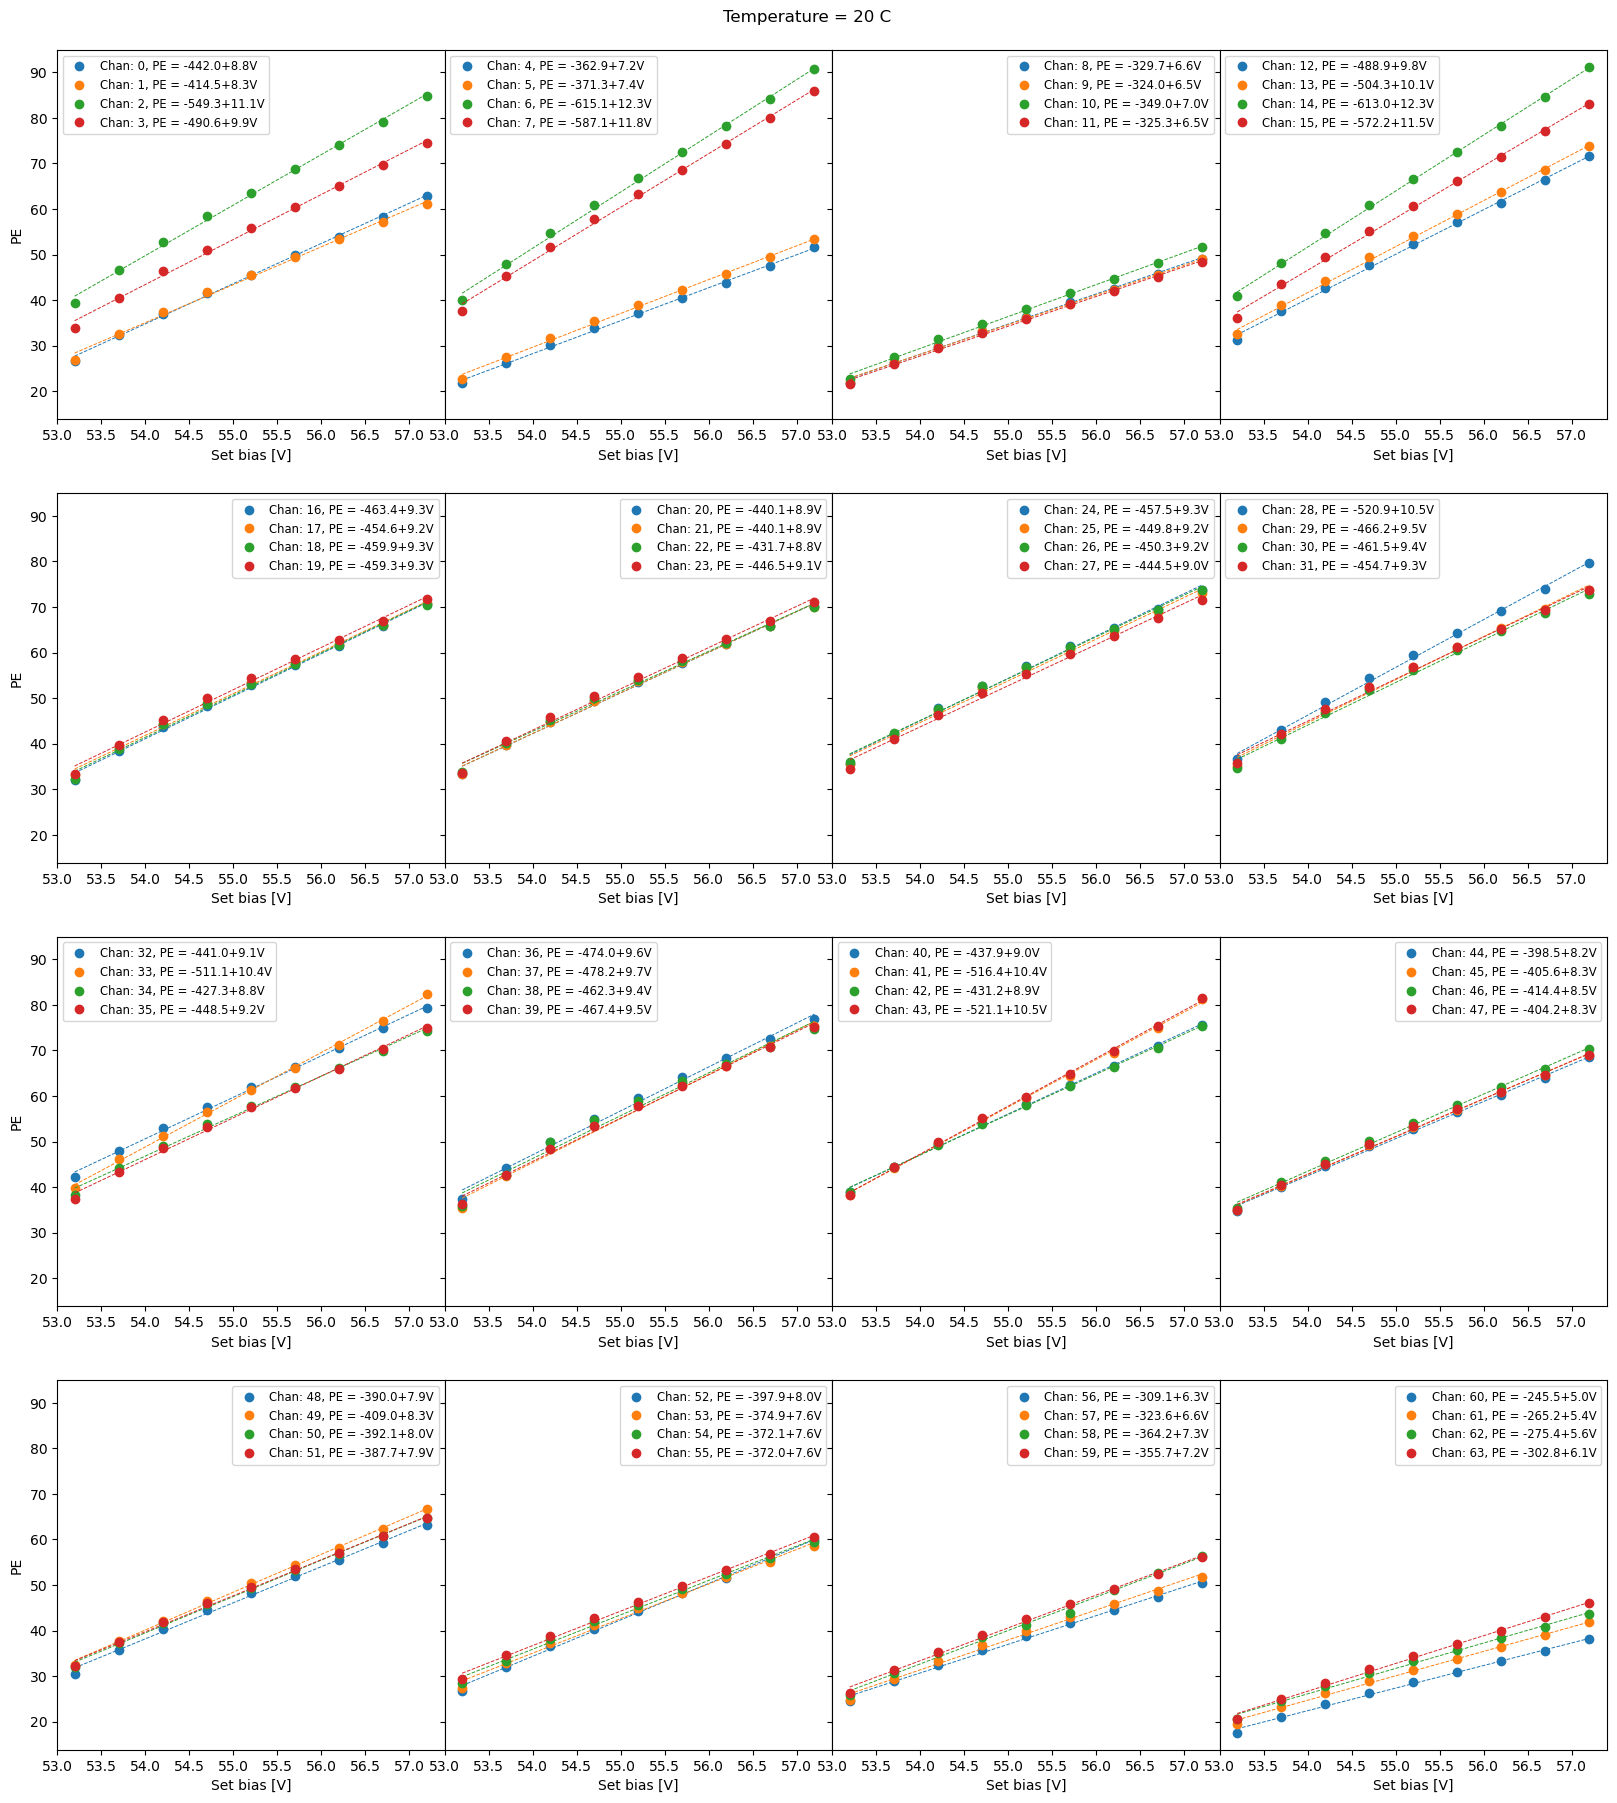

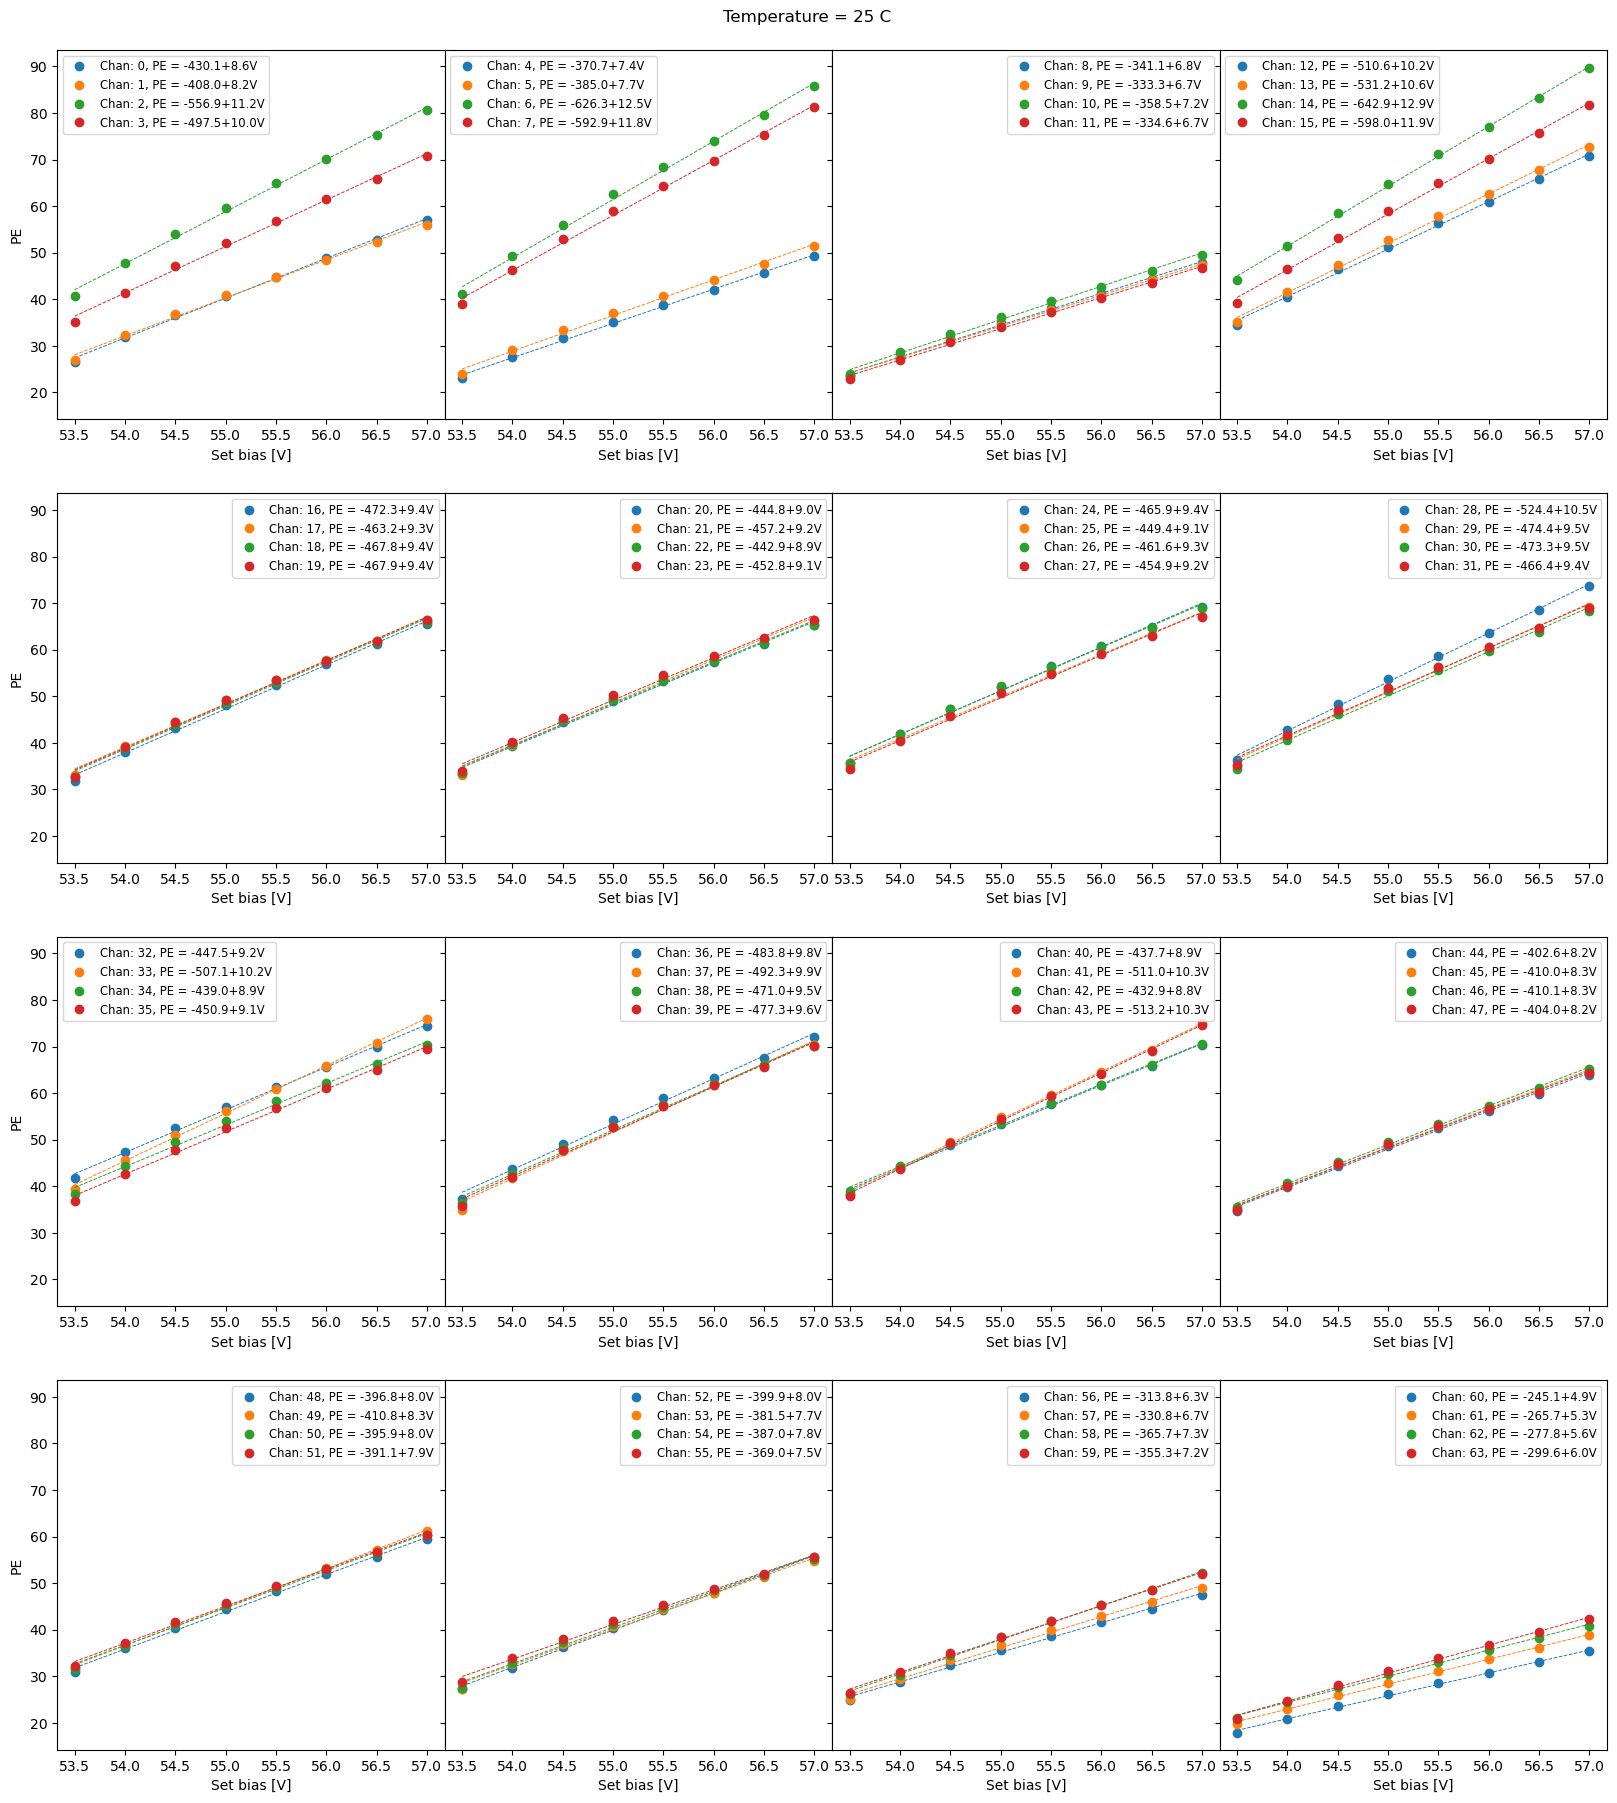

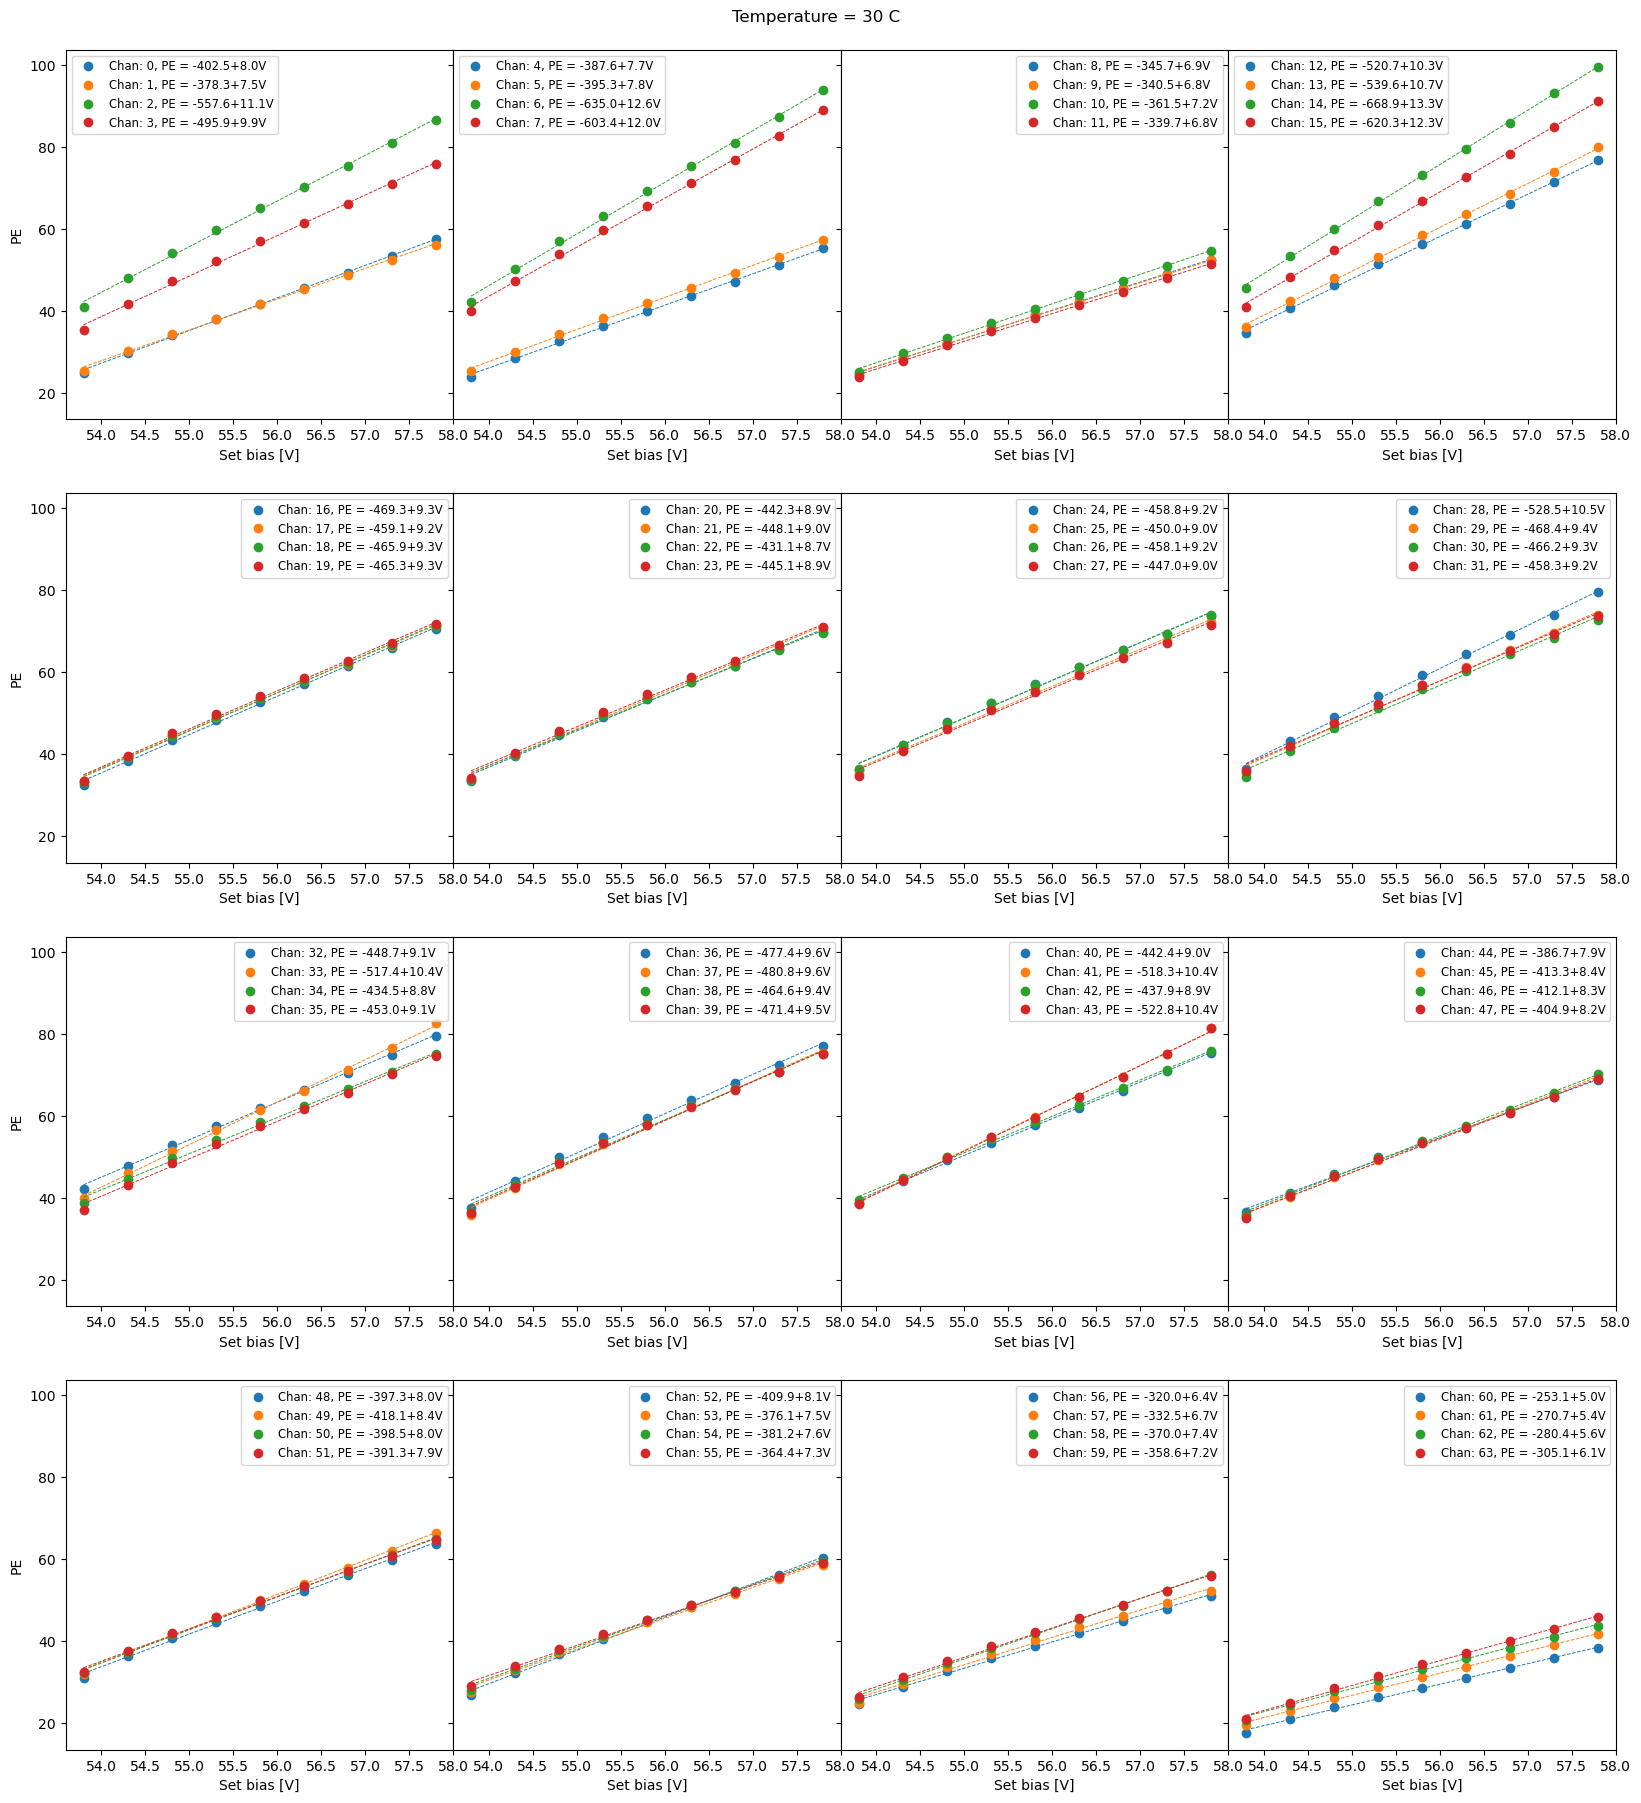

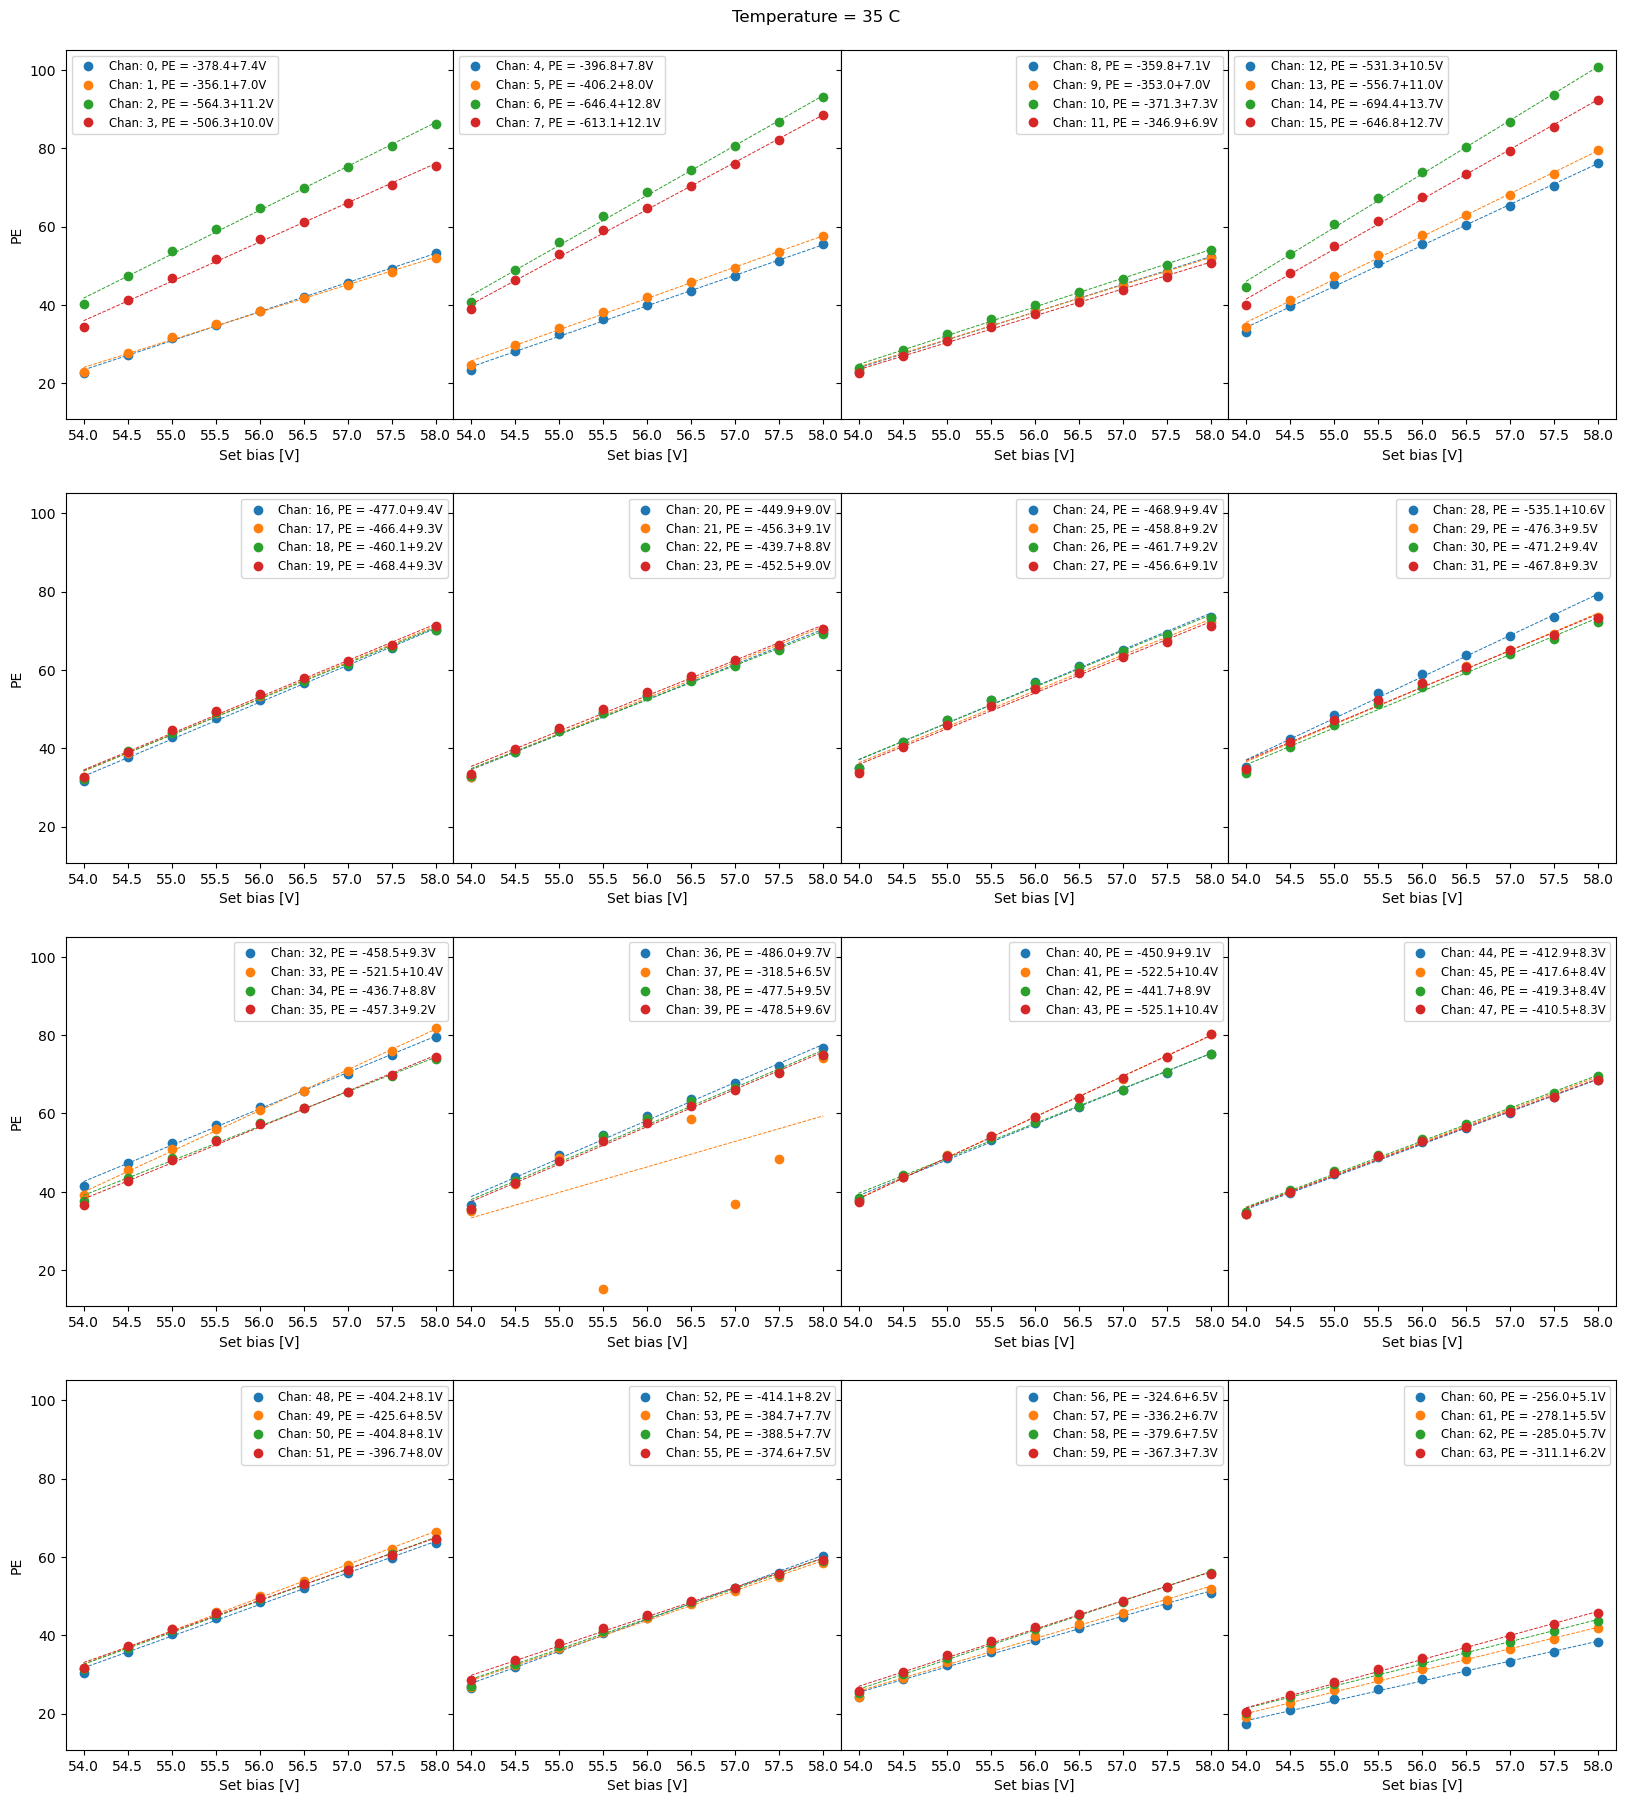

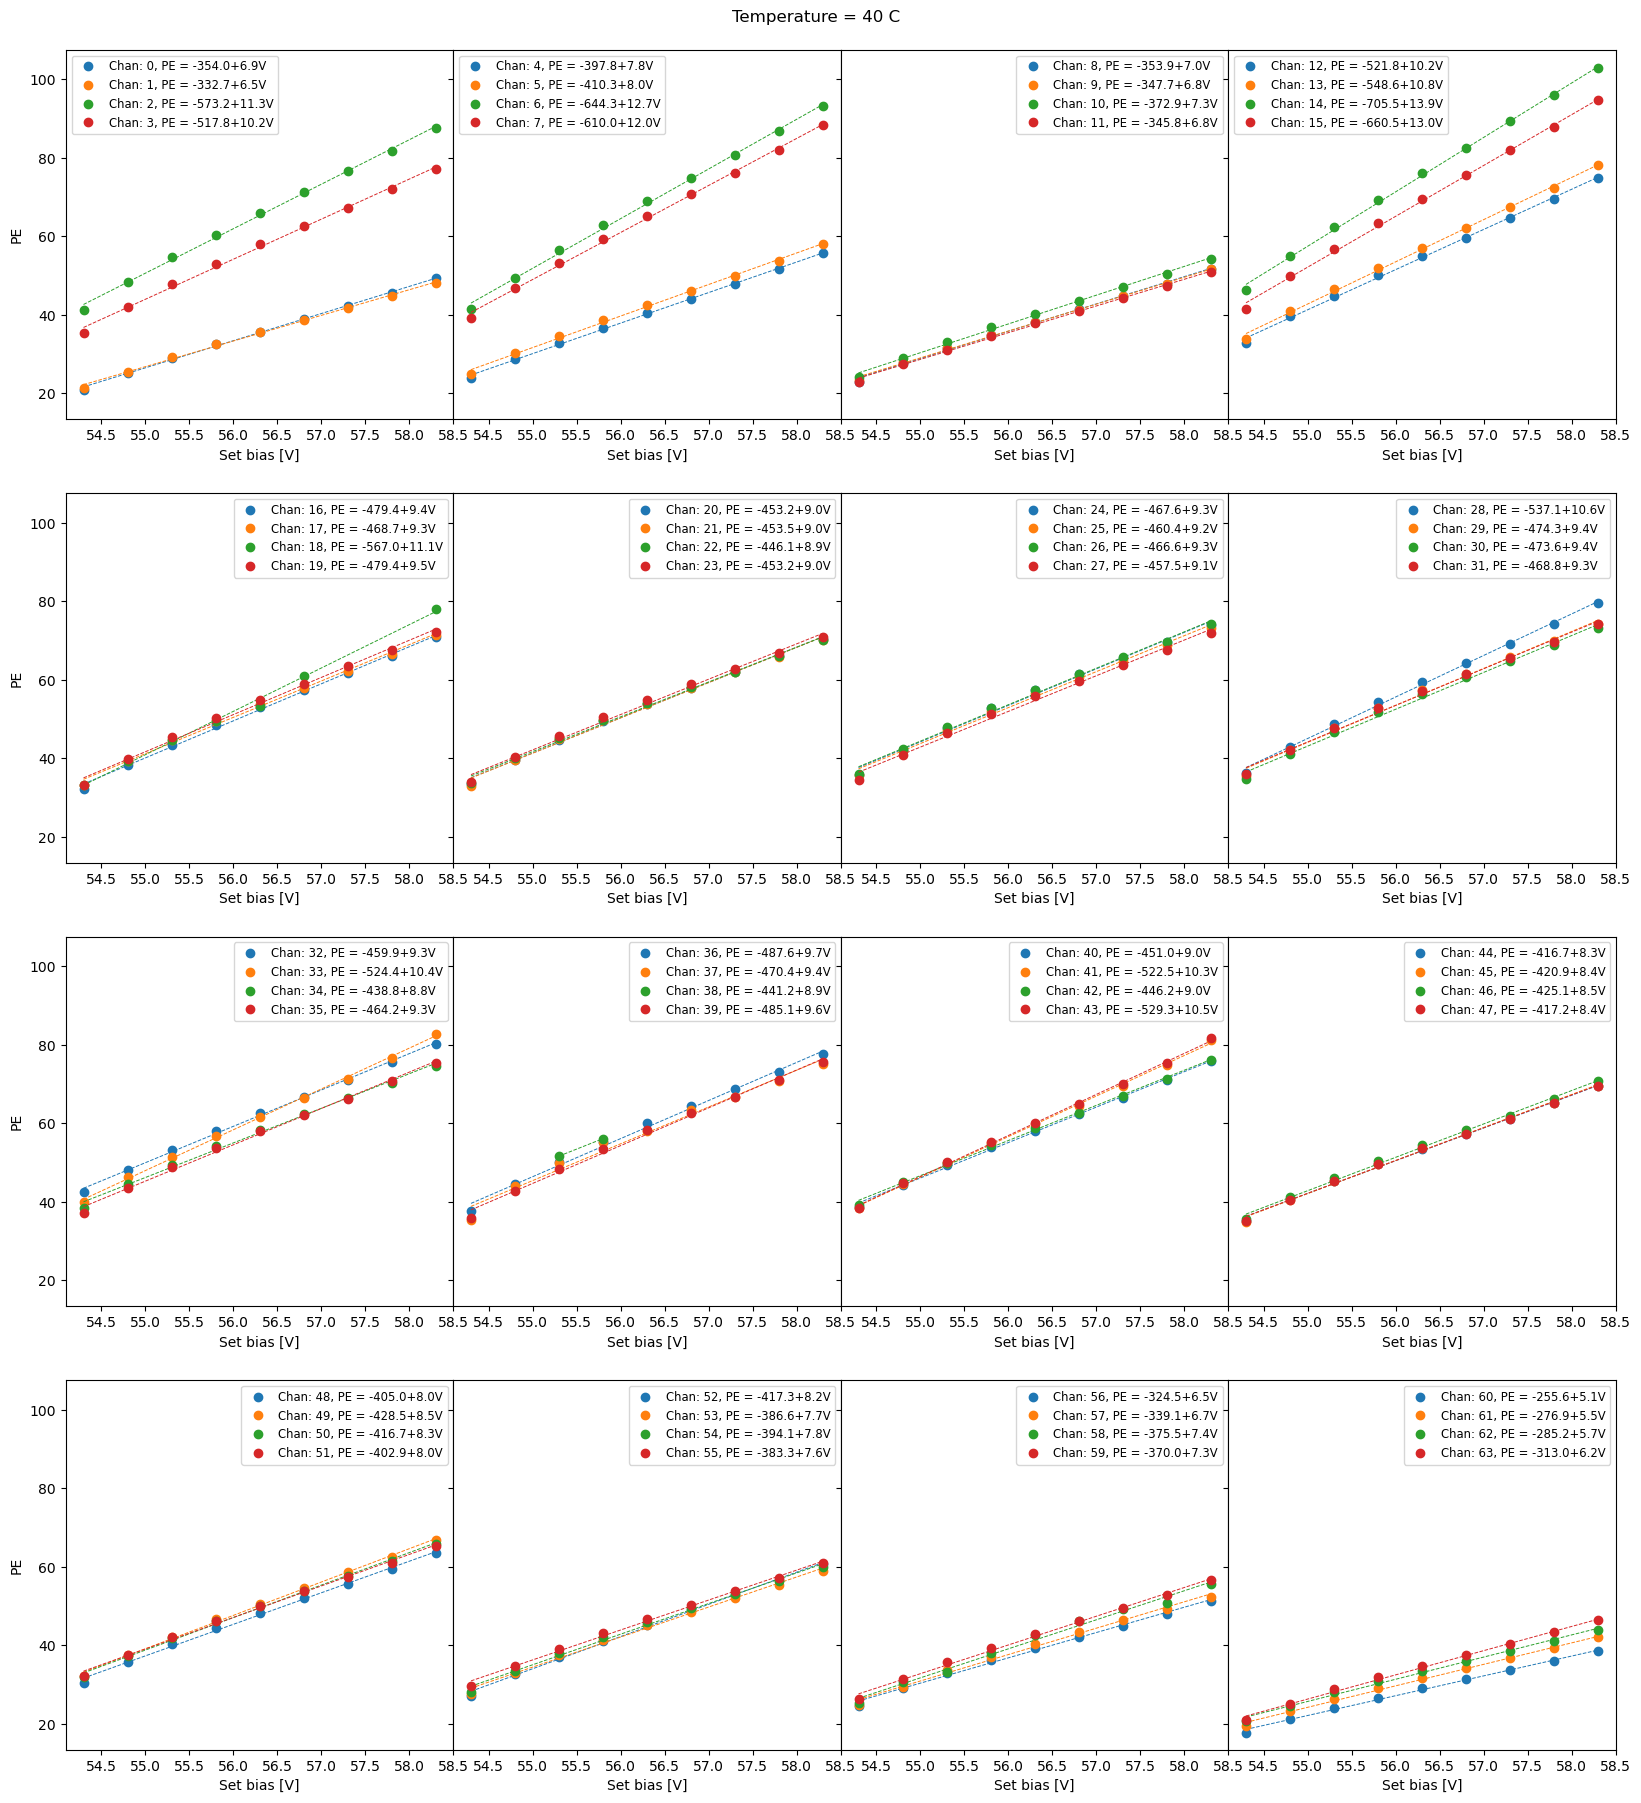

In [3]:
df = pd.DataFrame()

for idx, temp in enumerate(templist):
    processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist[idx], userunlist=True, remove=False)
    arr, arSpills = processor.getData(DATASET) # get akward array for "runSummary" tree
    
    if not np.array_equal(np.array(runlist[idx]), arr['runNumber'].to_numpy()):
        print("Input run list order and data do not match")
    
    #Mask channels which were not calibrated
    var = 'PEs'    
    arSPE = ak.mask(arr[var], arr[var]>0).to_numpy()
    
    df_tmp = processTemperature(arSPE, idx)
    df = pd.concat([df, df_tmp], ignore_index=True)

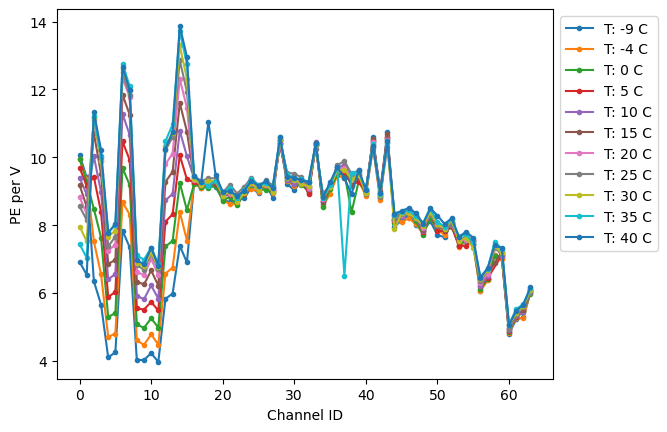

In [4]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['slope'], '.-', label=('T: %d C'%temp))
plt.xlabel("Channel ID")
plt.ylabel("PE per V");
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

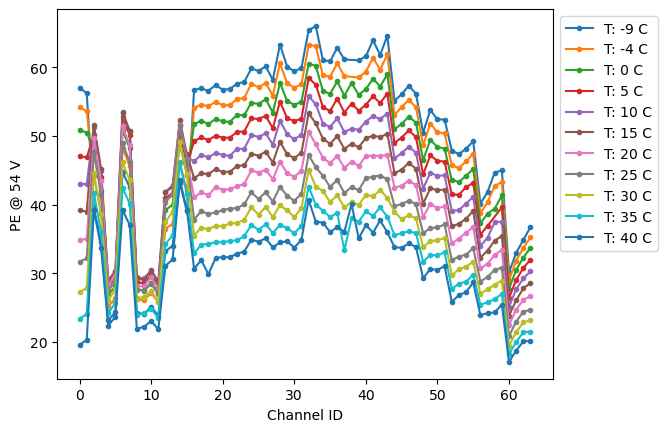

In [5]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['spe_54V_fix'], '.-', label=('T: %d C'%temp))
plt.xlabel("Channel ID")
plt.ylabel("PE @ 54 V");
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

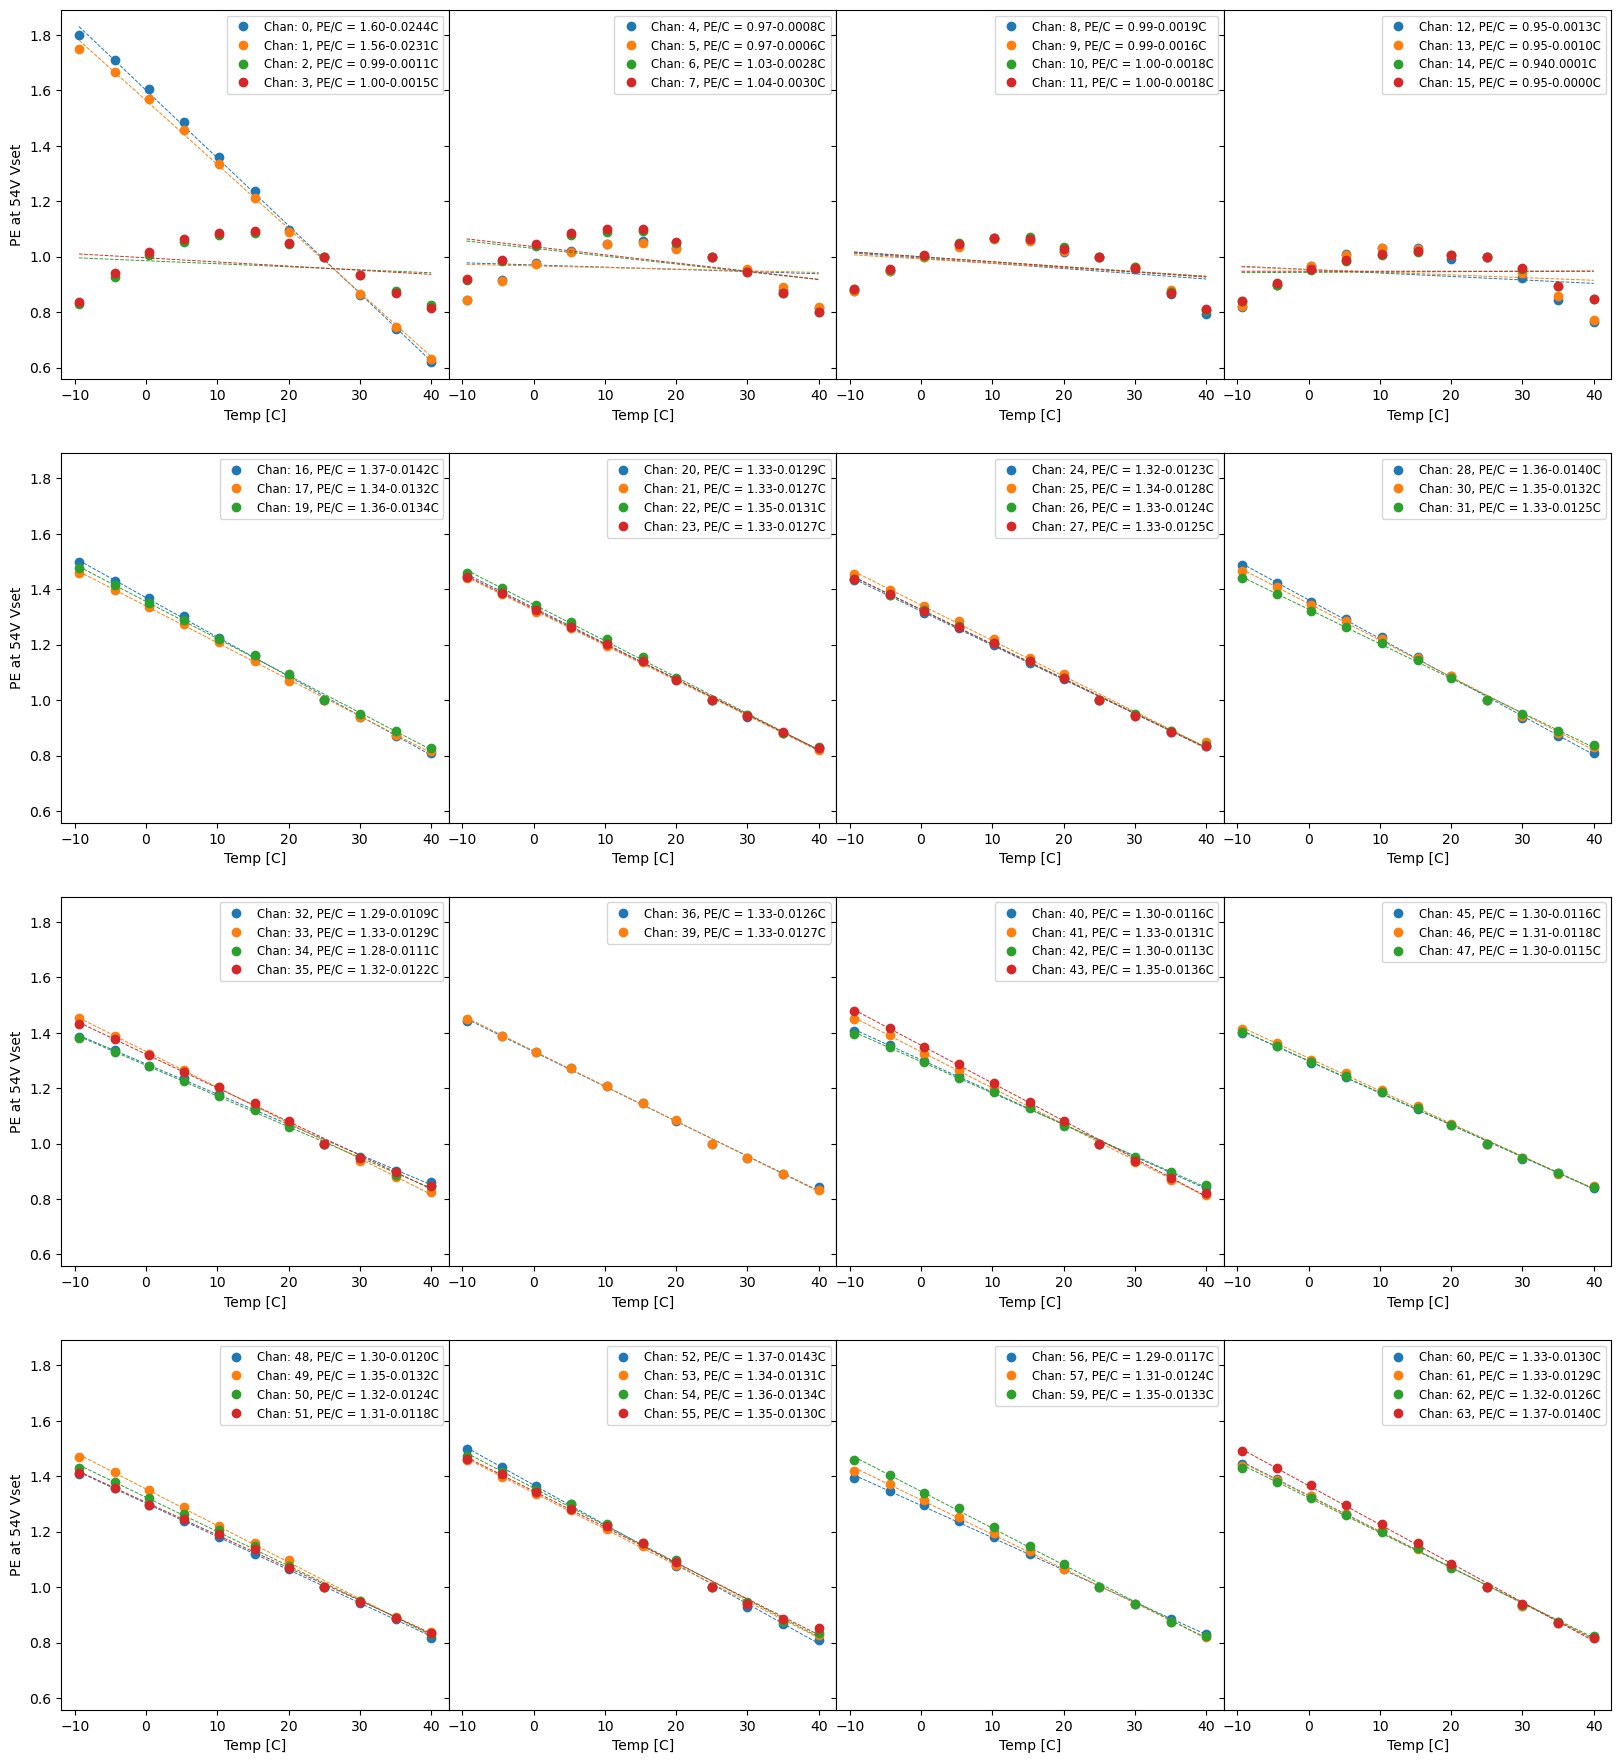

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

dfSPE_Temp = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])


for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("PE at 54V Vset")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in badchannels:
            continue
            
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['spe_54V_fix'].to_numpy()
        y=y/y[7]

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, PE/C = %.2f%.4fC'%(chan, intercept, slope))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        dfSPE_Temp.loc[len(dfSPE_Temp)] = new_row

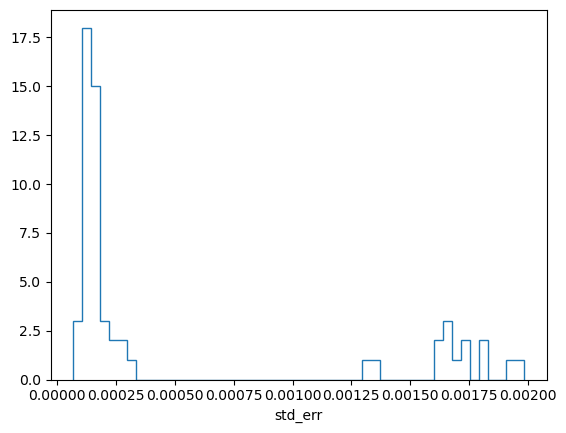

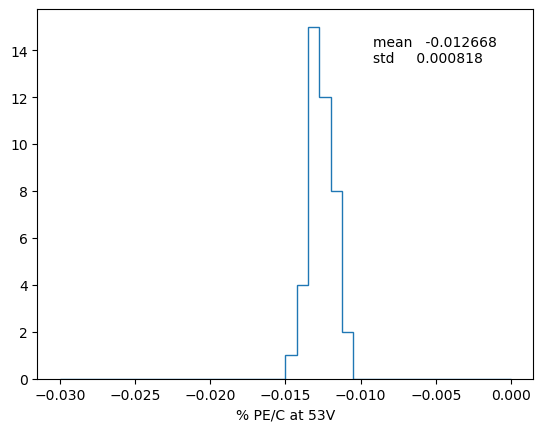

In [7]:
plt.hist(dfSPE_Temp['std_err'], histtype='step', bins=50);
plt.xlabel('std_err')
plt.figure()
plt.hist(dfSPE_Temp.query('std_err<0.3 & chan > 15')['slope'], histtype='step', bins=40, range=(-0.03,0));
plt.xlabel('% PE/C at 53V');
plt.figtext(0.65,0.77, dfSPE_Temp.query('std_err<0.3 & chan > 15')['slope'].describe().loc[['mean','std']].to_string());

In [8]:
pd.set_option('display.max_rows', None)
df

chan      slope  temp   intercept   r_value       p_value    std_err  \
0       0  10.075439  -9.4 -487.042793  0.998738  2.346506e-10   0.918689   
1       1   9.405028  -9.4 -451.680047  0.996811  6.014058e-09   1.453221   
2       2   6.345351  -9.4 -303.216714  0.999657  2.466256e-12   0.473349   
3       3   5.657237  -9.4 -270.923807  0.997065  4.494564e-09   1.389749   
4       4   4.103566  -9.4 -198.447206  0.999455  1.246746e-11   0.603921   
5       5   4.250382  -9.4 -205.204292  0.998633  3.104143e-10   0.955047   
6       6   7.840758  -9.4 -378.658251  0.999367  2.095755e-11   0.649596   
7       7   7.346178  -9.4 -354.160346  0.999094  7.350476e-11   0.775981   
8       8   4.021618  -9.4 -192.926991  0.998753  2.252756e-10   0.906405   
9       9   4.026171  -9.4 -193.339142  0.997606  2.205177e-09   1.258155   
10     10   4.227364  -9.4 -203.167948  0.999154  5.805500e-11   0.747887   
11     11   3.967947  -9.4 -190.444998  0.998421  5.145993e-10   1.020735   
12     12   5.829128  -9.4 -281.579492  0.998548  3.832981e-10   0.984876   
13     13   5.982562  -9.4 -289.051962  0.998900  1.450668e-10   0.857147   
14     14   7.392167  -9.4 -356.026348  0.999485  1.019823e-11   0.584427   
15     15   6.900441  -9.4 -333.619152  0.999294  3.078588e-11   0.687092   
16     16   9.240468  -9.4 -442.298745  0.998237  7.555321e-10   1.075544   
17     17   9.083454  -9.4 -433.572284  0.998665  2.855195e-10   0.932991   
18     18   9.168650  -9.4 -438.551516  0.998485  4.447117e-10   0.996194   
19     19   9.124568  -9.4 -435.327601  0.998312  6.492060e-10   1.048990   
20     20   8.770303  -9.4 -416.857581  0.997568  2.329668e-09   1.255167   
21     21   8.667544  -9.4 -411.235342  0.998281  6.919307e-10   1.052757   
22     22   8.743363  -9.4 -414.512765  0.996506  8.275105e-09   1.501893   
23     23   8.802512  -9.4 -417.477767  0.997283  3.434758e-09   1.324194   
24     24   9.108786  -9.4 -432.052804  0.996947  5.163693e-09   1.404191   
25     25   8.937855  -9.4 -423.185783  0.996818  5.966027e-09   1.431061   
26     26   9.212525  -9.4 -437.367634  0.997176  3.930388e-09   1.351441   
27     27   8.809138  -9.4 -417.531949  0.998202  8.095205e-10   1.075619   
28     28  10.502396  -9.4 -503.819952  0.998533  3.972779e-10   0.983103   
29     29   9.210318  -9.4 -437.276608  0.997940  1.304451e-09   1.153680   
30     30   9.034219  -9.4 -428.453537  0.997863  1.482471e-09   1.173771   
31     31   9.297228  -9.4 -442.155922  0.996112  1.202438e-08   1.589786   
32     32   8.948549  -9.4 -417.859504  0.999540  6.860972e-12   0.535409   
33     33  10.355051  -9.4 -493.157322  0.999129  6.417394e-11   0.751814   
34     34   8.614330  -9.4 -404.178189  0.998484  4.464886e-10   0.977750   
35     35   9.198696  -9.4 -435.855370  0.997764  1.736974e-09   1.199650   
36     36   9.590935  -9.4 -455.078485  0.996377  9.393882e-09   1.530814   
37     37   9.446834  -9.4 -449.001679  0.996781  6.212677e-09   1.444940   
38     39   9.379919  -9.4 -445.509333  0.996839  5.826117e-09   1.430664   
39     40   8.921803  -9.4 -420.183389  0.999435  1.413703e-11   0.598808   
40     41  10.587684  -9.4 -507.806861  0.999001  1.035153e-10   0.810751   
41     42   8.797587  -9.4 -413.295671  0.999138  6.192674e-11   0.737835   
42     43  10.755577  -9.4 -516.192245  0.999518  8.084914e-12   0.563350   
43     44   7.947565  -9.4 -374.052448  0.999674  2.048623e-12   0.454010   
44     45   8.149871  -9.4 -384.030418  0.999070  8.061808e-11   0.768543   
45     46   8.295415  -9.4 -390.647202  0.999376  1.997242e-11   0.629086   
46     47   7.996879  -9.4 -375.684732  0.999223  4.305977e-11   0.700468   
47     48   7.815696  -9.4 -371.585872  0.997858  1.493652e-09   1.177958   
48     49   8.116351  -9.4 -384.517975  0.999549  6.433969e-12   0.538237   
49     50   7.711420  -9.4 -364.023733  0.998176  8.519519e-10   1.079139   
50     51   7.642580  -9.4 -360.317972  0.997917  1.354426e-09   1.151836   
5